Link to the google colab:
https://colab.research.google.com/drive/1UcHLgf6LOBbWV08ntyz653Oy1-Voq_vo?usp=sharing

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from matplotlib.pyplot import figure
import random
#setting seed so results are reproducible
SEED=1495449
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
cifar_train = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor()]),
)

cifar_test = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=False,
transform=transforms.Compose([transforms.ToTensor()]),
)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
mnist_train = torchvision.datasets.MNIST(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor()]),
)

mnist_test = torchvision.datasets.MNIST(
root="./",
download=True,
train=False,
transform=transforms.Compose([transforms.ToTensor()]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Part I: Implementations
The initial stage involves the implementation of the neural network, as well as the development of functions for training and testing.


### Part 1: Task 1: Implement a fully-connected neural network

In [ ]:
class Net(nn.Module):
  def __init__(self, dim, nclass, width, depth):
    """
    Initializes a fully connected neural network with the specified dimensions.

    Inputs:
    - dim : the dimension of the input.
    - nclass : the number of output classes for the prediction problem.
    - width : the width in each layer (we will consider all layers have the same width).
    - depth : the depth of the neural network (equals the number of hidden layers)
    """
    super().__init__()
    self.flatten = nn.Flatten() # Define the flatten layer
    self.fc1 = nn.Linear(dim, width)  # Define the first fully connected layer
    self.fc_hidden = nn.ModuleList([nn.Linear(width, width) for _ in range(depth)]) # Define the hidden layers 
    self.fc_out = nn.Linear(width, nclass)  # Define the fully connected layer
    self.relu = nn.ReLU() # Define the ReLU activation layer

  def forward(self, input):
    """Passes the input through the layers of the network and returns the output."""
    input = self.flatten(input)
    input = self.fc1(input)
    input = self.relu(input)

    # Pass the input through the hidden layers
    for fc in self.fc_hidden:
        input = fc(input)
        input = self.relu(input)

    output = self.fc_out(input)
    return output

### Part 1: Task 2: Implement the data loading function

In [ ]:
def loading_data(batch_size, train_set, test_set):
  """Returns two data loaders, 'trainloader' and 'testloader', which shuffle 
  the data (train set and test set) and batch it according to the given batch size"""
  trainloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)
  return trainloader, testloader

###Part 1: Task 3: Implement a function that does one training epoch

In [ ]:
def train_epoch(trainloader, net, optimizer, criterion):
  """
    Batch trains a neural network for one epoch using batches in 'trainloader' 
    and updates the network parameters using the optimizer.

    Inputs:
    trainloader (torch.utils.data.DataLoader): A DataLoader object containing the training data.
    net (nn.Module) : A neural network model.
    optimizer (torch.optim.Optimizer): An optimizer object for updating the network parameters.
    criterion (nn.Module) : A loss function for computing the loss.

    Returns:
    average_loss: The average loss overall all data points.
    """

  # Set the network to train mode
  net.train()
  running_loss = 0
  for inputs, labels in trainloader:
      optimizer.zero_grad() # Zero the gradients of the optimizer
      outputs = net(inputs)
      loss = criterion(outputs, labels) # Compute the loss
      loss.backward() # Compute the gradients
      optimizer.step()  # Take an update step
      running_loss += loss.item()
  
  # Compute the average loss over all datapoints
  average_loss = running_loss/len(trainloader)
  return average_loss

###Part 1: Task 4: Implement a function that does one test epoch

In [ ]:
def test_epoch(testloader, net, criterion):
  """Evaluate the performance of a neural network on a test set.
  
  Input:
    testloader (torch.utils.data.DataLoader): The data loader for the test set.
    net (nn.Module): The neural network to evaluate.
    criterion (nn.Module): The loss function to use for evaluation.
    
  Returns:
    tuple: A tuple containing the average loss and error over all datapoints in the test set.
  """
  
  running_loss = 0
  running_error = 0
  net.eval()  # Set the model to evaluation mode
  
  for inputs, labels in testloader:
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      # Find the predicted class by finding the index of the maximum value in the output
      _, predicted = torch.max(outputs, 1)
      
      # Compare the predicted class to the true label and count the number of incorrect predictions
      running_error += (predicted != labels).sum().item()
  
  # Compute the average loss and error over all datapoints
  avg_loss = running_loss / len(testloader)
  avg_error = running_error / len(testloader.dataset)
  
  return avg_loss, avg_error

###Part 1: Task 5: Write a piece of code that sets the hyperparameters and that allows to run the train and test epochs

In [ ]:
# Define the hyperparameters
batch_size = 64
dim_cifar = 3072
dim_mnist = 28 * 28
nclass = 10
width = 50
depth = 4
learning_rate = 0.001
epoch_limit = 20

# Load the MNIST datasets
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)

# Load the CIFAR 10 datasets
train_set_cifar, test_set_cifar = loading_data(batch_size, cifar_train, cifar_test)

"""Note the default version of cross entropy calculates the mean loss over all 
points in a batch. Hence we divide the averages in train_spoch and test epoch ny 
number of batches to calculate the averages over all datapoints in the dataset."""
criterion = nn.CrossEntropyLoss() # Define the Cross Entropy as the criterion 

In [ ]:
def run_epochs(epoch_limit, train_set, test_set, net, optimizer, criterion, stopping_criteria=False):
  """
    Train and evaluate a neural network for multiple epochs.

    Inputs:
    epoch_limit : number of epochs to run.
    train_set (torch.utils.data.DataLoader): the training dataset.
    test_set (torch.utils.data.DataLoader) : the test dataset.
    net : the neural network to train and evaluate.
    optimizer : the optimizer to use for training.
    criterion (torch.nn.Module): the loss function to use for training and evaluation.

    Returns:
    train_loss_list (list): a list of average training losses, one for each epoch.
    test_loss_list (list): a list of average test losses, one for each epoch.
    test_error_list (list): a list of average test errors, one for each epoch.
    """

  train_loss_list = []
  test_loss_list = []
  test_error_list = []
  if stopping_criteria:
    epoch_limit=2000

  for epoch in range(epoch_limit):
    train_loss = train_epoch(train_set, net, optimizer, criterion)  # Run a train epoch
    test_loss, test_error = test_epoch(test_set, net, criterion)  # Run a test epoch
    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss} | Test Error: {test_error}")

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_error_list.append(test_error)

    if stopping_criteria:
      if train_loss < stopping_criteria:
        break

  return train_loss_list, test_loss_list, test_error_list

Cross-entropy is a measure of the difference between two probability distributions. The cross-entropy between the predicted probability distribution and the true distribution measures the amount of information lost when using the predicted distribution to approximate the true distribution. By minimizing the cross-entropy loss during training, the model learns to better predict the true probability distribution of the classes and improves its classification accuracy. The formula for cross-entropy loss uses softmax activation and can be found in lecture notes.


Adam optimizer is a type of adaptive learning rate algorithm that computes individual adaptive learning rates for different parameters from estimates of the first and second moments of the gradients. Specifically, Adam computes a moving average of the gradients and their squared values, which are then used to scale the learning rate for each parameter.
Although we have set the momentum to 0 at various points in our code, adam can also use momentum terms to adjust the gradient descent step and a bias correction mechanism to remove the bias introduced by the moving averages in the initial iterations of the optimization process. The Adam optimizer is known for its ability to adapt the learning rate for each parameter and momentum term, making it very effective in dealing with noisy or sparse gradients.



#####For MNIST dataset

In [ ]:
# Create the network
net_mnist = Net(dim_mnist, nclass, width, depth)

# Define the adam optimizer
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)

train_loss_mnist, test_loss_mnist, test_error_mnist = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.5299085219865287 | Test Loss: 0.28801929974442075 | Test Error: 0.0883
Epoch: 1 | Train Loss: 0.2124808178777729 | Test Loss: 0.17875773459672928 | Test Error: 0.0548
Epoch: 2 | Train Loss: 0.15306497941504538 | Test Loss: 0.1494714538062549 | Test Error: 0.0468
Epoch: 3 | Train Loss: 0.12355088013639329 | Test Loss: 0.15588294467918432 | Test Error: 0.048
Epoch: 4 | Train Loss: 0.10285240597923649 | Test Loss: 0.13051406843409796 | Test Error: 0.0391
Epoch: 5 | Train Loss: 0.08881639918314416 | Test Loss: 0.1143795092690997 | Test Error: 0.0359
Epoch: 6 | Train Loss: 0.08042682324678127 | Test Loss: 0.1120841344699833 | Test Error: 0.0328
Epoch: 7 | Train Loss: 0.07066619808578105 | Test Loss: 0.11862840323418283 | Test Error: 0.035
Epoch: 8 | Train Loss: 0.06465308824956202 | Test Loss: 0.10030173234772055 | Test Error: 0.028
Epoch: 9 | Train Loss: 0.05878429032831407 | Test Loss: 0.11463272602929123 | Test Error: 0.0338
Epoch: 10 | Train Loss: 0.053694908951

#####For CIFAR 10 dataset

In [ ]:
net_cifar = Net(dim_cifar, nclass, width, depth)

# Define the adam optimizer
optimizer_cifar = torch.optim.Adam(net_cifar.parameters(), lr=learning_rate)

train_loss_cifar, test_loss_cifar, test_error_cifar = run_epochs(epoch_limit, train_set_cifar, test_set_cifar, net_cifar, optimizer_cifar, criterion)

Epoch: 0 | Train Loss: 1.9497324417314261 | Test Loss: 1.8281987647342075 | Test Error: 0.6712
Epoch: 1 | Train Loss: 1.7690253664770395 | Test Loss: 1.7578271877993443 | Test Error: 0.6477
Epoch: 2 | Train Loss: 1.6856298445130857 | Test Loss: 1.6515602450461904 | Test Error: 0.5927
Epoch: 3 | Train Loss: 1.6360954950227762 | Test Loss: 1.602492051519406 | Test Error: 0.5719
Epoch: 4 | Train Loss: 1.5902473921970943 | Test Loss: 1.581114841874238 | Test Error: 0.5664
Epoch: 5 | Train Loss: 1.55955542551587 | Test Loss: 1.555320565867576 | Test Error: 0.5604
Epoch: 6 | Train Loss: 1.5339957315598607 | Test Loss: 1.5454303648821108 | Test Error: 0.5584
Epoch: 7 | Train Loss: 1.5156510373210663 | Test Loss: 1.5300267031238337 | Test Error: 0.548
Epoch: 8 | Train Loss: 1.492156365643377 | Test Loss: 1.510863667840411 | Test Error: 0.5451
Epoch: 9 | Train Loss: 1.4688953992046054 | Test Loss: 1.5332268210733013 | Test Error: 0.5494
Epoch: 10 | Train Loss: 1.4550574116999535 | Test Loss: 1.

It is clear that our function and neural network is operation from running 20 epochs for both datsets above.

#Part II: Numerical exploration

Now we will work with a neural network on the MNIST dataset to understand how the choice of hyperparameters affects its performance in terms of train and test error. 

###Part 2: Task 6: Analyse the performance for wide vs. deep neural networks
I am using a neural network architecture with 256 nodes at each layer, a batch size of 64, and a learning rate of 0.001. I will be evaluating the network's performance at each depth for a total of 50 epochs. I am using Adam optimizer.

In [ ]:
# Define the hyperparameters
batch_size = 64
dim_mnist = 28 * 28
nclass = 10
width = 256
epoch_limit = 50
learning_rate = 0.001

# Load the MNIST datasets
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)

###### For Depth = 1 with Adam optimizer

In [ ]:
depth = 1
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_1_adam, test_loss_1_adam, test_error_1_adam = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.2661858993544698 | Test Loss: 0.11112544290531592 | Test Error: 0.0353
Epoch: 1 | Train Loss: 0.09924407315446433 | Test Loss: 0.10032671696215772 | Test Error: 0.0317
Epoch: 2 | Train Loss: 0.06591490789009795 | Test Loss: 0.07663348610186653 | Test Error: 0.0231
Epoch: 3 | Train Loss: 0.047090185297924136 | Test Loss: 0.07010007331927846 | Test Error: 0.0208
Epoch: 4 | Train Loss: 0.03641257700852867 | Test Loss: 0.07547997658075706 | Test Error: 0.0215
Epoch: 5 | Train Loss: 0.029877265935101215 | Test Loss: 0.0649089499203945 | Test Error: 0.0199
Epoch: 6 | Train Loss: 0.02316605497673124 | Test Loss: 0.07149495227243098 | Test Error: 0.0194
Epoch: 7 | Train Loss: 0.019112263210846653 | Test Loss: 0.07796278565708299 | Test Error: 0.02
Epoch: 8 | Train Loss: 0.01783704867852927 | Test Loss: 0.0822029949595394 | Test Error: 0.0203
Epoch: 9 | Train Loss: 0.014956627322885796 | Test Loss: 0.0773629076427789 | Test Error: 0.0181
Epoch: 10 | Train Loss: 0.011046

In [ ]:
print(train_loss_1_adam)
print(test_loss_1_adam)
print(test_error_1_adam)

[0.2661858993544698, 0.09924407315446433, 0.06591490789009795, 0.047090185297924136, 0.03641257700852867, 0.029877265935101215, 0.02316605497673124, 0.019112263210846653, 0.01783704867852927, 0.014956627322885796, 0.011046328315685324, 0.017463416248006312, 0.009060374535828232, 0.01303169298886939, 0.010833567465302915, 0.010216962553298603, 0.008703733083406398, 0.008619495542517659, 0.00958801466041318, 0.009263507680808632, 0.005951536312275413, 0.008122969726862777, 0.006745273021983512, 0.007241299254866532, 0.010368704700393878, 0.00587088850984955, 0.007153360748376106, 0.007171936459884287, 0.00681404017191831, 0.005949408716690523, 0.005399883494701704, 0.007533144172520279, 0.006223971526687527, 0.006485284710590231, 0.006617094231792819, 0.004230586233832967, 0.003399257154200555, 0.006822941886456437, 0.0054601556327287274, 0.005042350753749911, 0.006949743338297244, 0.004284786469966402, 0.006815340258827601, 0.004307483563780077, 0.0020148486686044653, 0.0088808034821064

######For Depth = 5 with Adam optimizer

In [ ]:
depth = 5
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_5_adam, test_loss_5_adam, test_error_5_adam = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.3362643423238034 | Test Loss: 0.16671751429486997 | Test Error: 0.0489
Epoch: 1 | Train Loss: 0.13019689347849153 | Test Loss: 0.10456613911861543 | Test Error: 0.0298
Epoch: 2 | Train Loss: 0.08953446331771532 | Test Loss: 0.10777648254801893 | Test Error: 0.029
Epoch: 3 | Train Loss: 0.07395556991831012 | Test Loss: 0.10971446680854176 | Test Error: 0.0286
Epoch: 4 | Train Loss: 0.061298031152584954 | Test Loss: 0.1171892136342788 | Test Error: 0.03
Epoch: 5 | Train Loss: 0.05033043167938087 | Test Loss: 0.09253514172497448 | Test Error: 0.0225
Epoch: 6 | Train Loss: 0.04357252214937337 | Test Loss: 0.09334656546725803 | Test Error: 0.0226
Epoch: 7 | Train Loss: 0.04040561272449462 | Test Loss: 0.10576303684001397 | Test Error: 0.0256
Epoch: 8 | Train Loss: 0.03435714258402184 | Test Loss: 0.08029083548426802 | Test Error: 0.0185
Epoch: 9 | Train Loss: 0.03254522201806665 | Test Loss: 0.12291538415261158 | Test Error: 0.0213
Epoch: 10 | Train Loss: 0.02834292

In [ ]:
print(train_loss_5_adam)
print(test_loss_5_adam)
print(test_error_5_adam)

[0.3362643423238034, 0.13019689347849153, 0.08953446331771532, 0.07395556991831012, 0.061298031152584954, 0.05033043167938087, 0.04357252214937337, 0.04040561272449462, 0.03435714258402184, 0.03254522201806665, 0.02834292160440373, 0.027212013000548034, 0.02269677254765162, 0.024103540873121738, 0.019293748705048547, 0.02017530907894457, 0.01996721678690736, 0.016321264619053952, 0.015623026603582455, 0.017094240009324982, 0.014545555332664644, 0.015262087241294983, 0.01244106774830933, 0.011993260074679626, 0.01134964708242772, 0.014455083746592613, 0.010180546417823365, 0.015132286596031226, 0.012186478807764741, 0.013692034140541803, 0.007105803836050748, 0.010710916011493939, 0.013076253919738578, 0.012711530259845543, 0.012971512654462768, 0.006603027986988272, 0.008140226727841543, 0.010341614623194394, 0.009256334772390618, 0.007086812363872493, 0.006449300070581041, 0.011737449254913256, 0.00843542615317346, 0.007812407310853728, 0.007087991021988384, 0.008670917331402328, 0.00

######For Depth = 10 with Adam optimizer

In [ ]:
depth = 10
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_10_adam, test_loss_10_adam, test_error_10_adam = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.7096969194448134 | Test Loss: 0.23700428863239895 | Test Error: 0.0653
Epoch: 1 | Train Loss: 0.20689631102066527 | Test Loss: 0.2348234148067274 | Test Error: 0.0526
Epoch: 2 | Train Loss: 0.15108191889466477 | Test Loss: 0.18655302637749038 | Test Error: 0.0433
Epoch: 3 | Train Loss: 0.17162313391474376 | Test Loss: 0.17746659500263395 | Test Error: 0.0405
Epoch: 4 | Train Loss: 0.11771687806677272 | Test Loss: 0.13699754560662872 | Test Error: 0.0323
Epoch: 5 | Train Loss: 0.14351333960094478 | Test Loss: 0.13611430905842384 | Test Error: 0.0307
Epoch: 6 | Train Loss: 0.10987933833752253 | Test Loss: 0.12680569964395777 | Test Error: 0.0325
Epoch: 7 | Train Loss: 0.08410215047910424 | Test Loss: 0.15046537353933023 | Test Error: 0.0327
Epoch: 8 | Train Loss: 0.08496513129420467 | Test Loss: 0.14373016715714126 | Test Error: 0.0313
Epoch: 9 | Train Loss: 0.07966449458386252 | Test Loss: 0.131259052240094 | Test Error: 0.0265
Epoch: 10 | Train Loss: 0.06668887

In [ ]:
print(train_loss_10_adam)
print(test_loss_10_adam)
print(test_error_10_adam)

[0.7096969194448134, 0.20689631102066527, 0.15108191889466477, 0.17162313391474376, 0.11771687806677272, 0.14351333960094478, 0.10987933833752253, 0.08410215047910424, 0.08496513129420467, 0.07966449458386252, 0.0666888770467077, 0.061392795821758675, 0.0514640178218992, 0.053943882243832696, 0.05514309198610415, 0.04985996488446885, 0.045820611576239324, 0.04031034664552793, 0.04489983365824812, 0.034315674057485895, 0.03821601481084567, 0.035506363219724696, 0.030237269204131185, 0.033593372484984646, 0.04030666246430951, 0.026509316205138293, 0.024991023985912256, 0.024027635476930858, 0.023633751357207456, 0.023484374303905892, 0.03242305757150829, 0.01950391992140513, 0.020495128730673065, 0.02018234462448471, 0.01954688924608544, 0.01891216135010645, 0.015832360827295233, 0.019538174285426143, 0.02169083088552003, 0.01767927910574472, 0.014843667450827634, 0.016339233355909345, 0.012047233306924367, 0.013035031830844574, 0.020425007362298003, 0.016918800656678872, 0.0103200351580

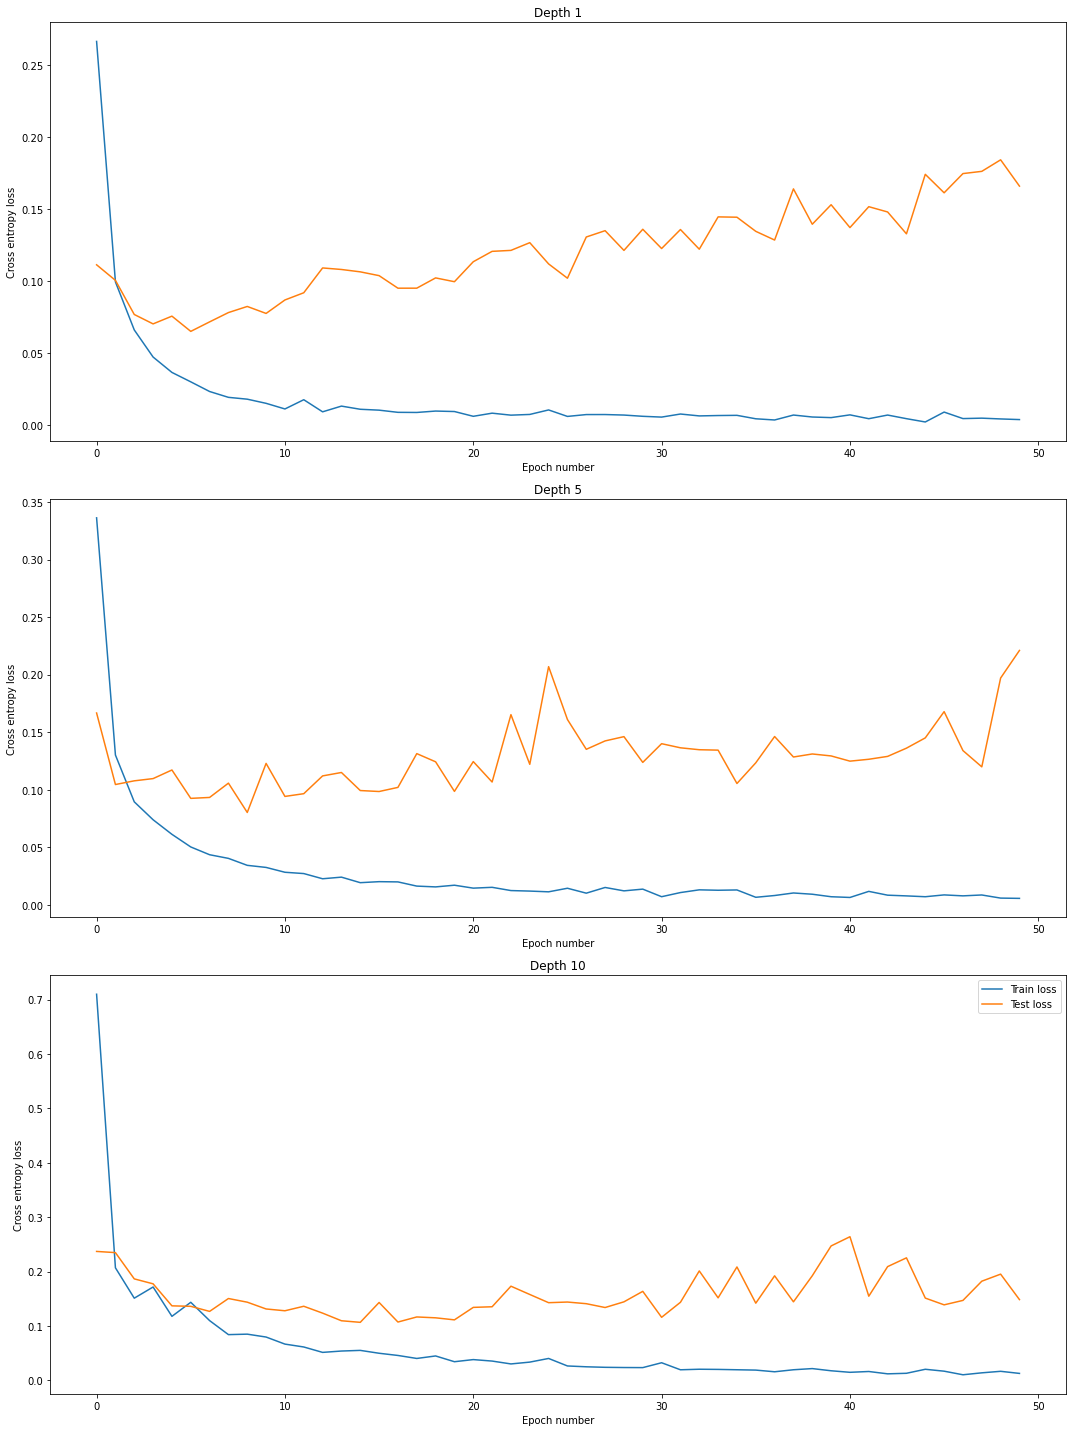

In [ ]:
figure, axis = plt.subplots(3, 1)
figure.set_size_inches(15, 20)

axis[0].plot(train_loss_1_adam, label = 'Train loss')
axis[0].plot(test_loss_1_adam, label = 'Test loss')
axis[0].set_title('Depth 1')

axis[1].plot(train_loss_5_adam, label = 'Train loss')
axis[1].plot(test_loss_5_adam, label = 'Test loss')
axis[1].set_title('Depth 5')

axis[2].plot(train_loss_10_adam, label = 'Train loss')
axis[2].plot(test_loss_10_adam, label = 'Test loss')
axis[2].set_title('Depth 10')

for i in range(3):
  axis[i].set_ylabel('Cross entropy loss')
  axis[i].set_xlabel('Epoch number')

plt.tight_layout()

plt.legend()
plt.show()

| Depth | Train loss | Test loss |Test Error |
| --- | --- | --- |--- |
| 1 | 0.0036790243873315743 | 0.16574773121684266 | 0.018
| 5 | 0.0056585355754046164 | 0.2210523909545943 | 0.0193
| 10 | 0.012827630596696261 | 0.14848695918570923 | 0.0173

The results show that train loss increases as the depth increases. I also notice that it test loss takes more epochs to start increasing for larger depth models (5 epochs for depth 1, 11 epochs for depth 5, and 19 epochs for depth 10). This means that we have a pattern that the shallower the model, the earlier the model starts to overfit.


I would have expected smaller training loss and larger test loss for larger depths (not what the results show) as with more parameters the model starts to become too complex and starts to memorise the training data rather than learn generalisable patterns. This is called overfitting. Not getting the expected result here could be attributed to to the fact that deeper models require more data and more epochs to train effectively.

Shallower models start to overfit earlier on because their train loss converges faster. As they have fewer parameters, its take fewer epochs to fine tune the weights and biases in the model.


These findings demonstrate the tradeoff between model complexity and performance when choosing the optimal depth for a neural network.

I am not training via SGD because it was very proving difficult to get SGD to converge especially for depth 10 for our specific problem. SGD was requiring a smaller learning rate than the Adam optimizer algorithm to converge, which in turn meant that I had to run the code for far more epochs to get the SGD algorithm to converge. One reason why SGD requires a smaller learning rate is that it does not adapt to the learning rate during training. In contrast, the Adam optimizer dynamically adjusts the learning rate for each parameter based on the estimated first and second moments of the gradients. This adaptation allows the Adam optimizer to converge faster and better handle ill-conditioned problems with different scales of the gradients.



###Part 2: Task 7: Compare SGD with small and large learning rates 

I will compare the performance of SGD optimizer with different learning rates, i.e., 0.001, 0.01, and 0.1. The experiment will performed with batch size 64 on a neural network with depth 1 and width 256 for 400 epochs. The goal is to analyze how the learning rate affects the model's learning.

In [ ]:
# Define the hyperparameters
depth = 1
width = 256
batch_size = 64
epoch_limit = 400

In [ ]:
learning_rate = 0.001
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_lr_001_adam, test_loss_lr_001_adam, test_error_lr_001_adam = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 2.2880100413426154 | Test Loss: 2.269466116170215 | Test Error: 0.6668
Epoch: 1 | Train Loss: 2.2482354323238707 | Test Loss: 2.2205706872757833 | Test Error: 0.4835
Epoch: 2 | Train Loss: 2.18697592164916 | Test Loss: 2.140504985857921 | Test Error: 0.4164
Epoch: 3 | Train Loss: 2.081973205370181 | Test Loss: 2.000798320314687 | Test Error: 0.3769
Epoch: 4 | Train Loss: 1.901504206504903 | Test Loss: 1.7683638926524266 | Test Error: 0.3402
Epoch: 5 | Train Loss: 1.6296748920544377 | Test Loss: 1.4572992393165638 | Test Error: 0.2921
Epoch: 6 | Train Loss: 1.3222937127674566 | Test Loss: 1.1635889126237031 | Test Error: 0.2269
Epoch: 7 | Train Loss: 1.068419870028872 | Test Loss: 0.948225811788231 | Test Error: 0.1957
Epoch: 8 | Train Loss: 0.891359428861248 | Test Loss: 0.8021047179865989 | Test Error: 0.1769
Epoch: 9 | Train Loss: 0.7706916618830105 | Test Loss: 0.7031389239487374 | Test Error: 0.1645
Epoch: 10 | Train Loss: 0.6860398727693537 | Test Loss: 0.63

In [ ]:
print(train_loss_lr_001_adam)
print(test_loss_lr_001_adam)
print(test_error_lr_001_adam)

[2.2880100413426154, 2.2482354323238707, 2.18697592164916, 2.081973205370181, 1.901504206504903, 1.6296748920544377, 1.3222937127674566, 1.068419870028872, 0.891359428861248, 0.7706916618830105, 0.6860398727693537, 0.6241379563869444, 0.5771500833634374, 0.5405418515078294, 0.5112238386864347, 0.48736540131223227, 0.4673424458452888, 0.4508515709975381, 0.4363253284682597, 0.42391954356037986, 0.41315204742303024, 0.4036556720606554, 0.39503727479974854, 0.3873950981858697, 0.38078668314828545, 0.37436501521355053, 0.36861987094253873, 0.363630153667698, 0.35861080065210743, 0.35402032822720025, 0.34972291863930505, 0.3458537174853435, 0.3418546635856125, 0.3382849512435099, 0.3349373825847594, 0.33149015732697334, 0.328371984665709, 0.32545823637229293, 0.32264402447574175, 0.3198914925998716, 0.3169147951929554, 0.31429482112402346, 0.3118283566810302, 0.30922262864644084, 0.30674440308070894, 0.30440518808072564, 0.3023919380549937, 0.29985844447160326, 0.2976090128678503, 0.2955785

In [ ]:
#sorry that the printout disappeared, i accidently merged this cell with the previous cell leading to the printout disapprearing.
#the list print is still there to verify the train loss, test loss and test error
learning_rate = 0.01
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_lr_01_adam, test_loss_lr_01_adam, test_error_lr_01_adam = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 1.662840264438312 | Test Loss: 0.7340716226085736 | Test Error: 0.1755
Epoch: 1 | Train Loss: 0.5380604615979103 | Test Loss: 0.4133283750266786 | Test Error: 0.1136
Epoch: 2 | Train Loss: 0.3869759891110697 | Test Loss: 0.3421566410429159 | Test Error: 0.0966
Epoch: 3 | Train Loss: 0.33757715936758115 | Test Loss: 0.30805043180941777 | Test Error: 0.0906
Epoch: 4 | Train Loss: 0.3090280880297679 | Test Loss: 0.2870070226253218 | Test Error: 0.0826
Epoch: 5 | Train Loss: 0.2878801864839947 | Test Loss: 0.273883251864819 | Test Error: 0.0775
Epoch: 6 | Train Loss: 0.2697498712505994 | Test Loss: 0.2548913692782639 | Test Error: 0.0722
Epoch: 7 | Train Loss: 0.25355007003810104 | Test Loss: 0.2401577773604803 | Test Error: 0.0686
Epoch: 8 | Train Loss: 0.23883570148460648 | Test Loss: 0.22591150142727004 | Test Error: 0.0639
Epoch: 9 | Train Loss: 0.22535663265298042 | Test Loss: 0.21623343710971485 | Test Error: 0.0621
Epoch: 10 | Train Loss: 0.21292124279161126 |

In [ ]:
print(train_loss_lr_01_adam)
print(test_loss_lr_01_adam)
print(test_error_lr_01_adam)

[1.662840264438312, 0.5380604615979103, 0.3869759891110697, 0.33757715936758115, 0.3090280880297679, 0.2878801864839947, 0.2697498712505994, 0.25355007003810104, 0.23883570148460648, 0.22535663265298042, 0.21292124279161126, 0.20110852555679615, 0.19036196503462569, 0.18060255900962646, 0.17147564412807542, 0.16294347546669022, 0.15537936524200097, 0.1479457515413001, 0.14110002862706558, 0.13495850458896078, 0.1294043554660322, 0.12383183706869512, 0.1187317687680504, 0.11366400784298555, 0.1092237318848083, 0.10478408602096125, 0.1008279623755657, 0.09698005387587334, 0.09338391679567473, 0.09001196716238917, 0.08666680998869859, 0.08376261314301729, 0.08069633741948459, 0.07811958976745256, 0.0753545834263886, 0.07284517050968972, 0.07039301841458215, 0.06809790464076422, 0.06585011634874398, 0.06379131699797076, 0.06174528228539997, 0.059887662244492025, 0.05789653360019567, 0.0560934155745539, 0.05446989894874378, 0.05309515493139545, 0.05131345364535207, 0.04981186708211025, 0.04

In [ ]:
learning_rate = 0.1
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_lr_1_adam, test_loss_lr_1_adam, test_error_lr_1_adam = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.4783001886263712 | Test Loss: 0.23780546622101667 | Test Error: 0.074
Epoch: 1 | Train Loss: 0.18151333961469024 | Test Loss: 0.1381082425760046 | Test Error: 0.0408
Epoch: 2 | Train Loss: 0.12148995364088812 | Test Loss: 0.10930326716843874 | Test Error: 0.0325
Epoch: 3 | Train Loss: 0.09055060118303768 | Test Loss: 0.0892813390085272 | Test Error: 0.0278
Epoch: 4 | Train Loss: 0.0706098125363861 | Test Loss: 0.08473717604591778 | Test Error: 0.0261
Epoch: 5 | Train Loss: 0.05815375390733634 | Test Loss: 0.08788723535361184 | Test Error: 0.0268
Epoch: 6 | Train Loss: 0.0474146103646769 | Test Loss: 0.07636670107140568 | Test Error: 0.0242
Epoch: 7 | Train Loss: 0.03962971434530332 | Test Loss: 0.06728966921200133 | Test Error: 0.0211
Epoch: 8 | Train Loss: 0.03262450175867704 | Test Loss: 0.06802902203112556 | Test Error: 0.0213
Epoch: 9 | Train Loss: 0.026612150664654756 | Test Loss: 0.06533472846813831 | Test Error: 0.0201
Epoch: 10 | Train Loss: 0.022369301

In [ ]:
print(train_loss_lr_1_adam)
print(test_loss_lr_1_adam)
print(test_error_lr_1_adam)

[0.4783001886263712, 0.18151333961469024, 0.12148995364088812, 0.09055060118303768, 0.0706098125363861, 0.05815375390733634, 0.0474146103646769, 0.03962971434530332, 0.03262450175867704, 0.026612150664654756, 0.022369301511480637, 0.018470704569504896, 0.014867739016737496, 0.012262166534489178, 0.010210472428189492, 0.008227714044942972, 0.006241067042004621, 0.004974955139433601, 0.004003353001608358, 0.003165505325002292, 0.0026242507413280496, 0.0022717041562279145, 0.0019674918249583686, 0.0017297505596005393, 0.0015712204299651077, 0.0014180157515612222, 0.0012715601908434718, 0.0011991805892778626, 0.001092166335643315, 0.0010127611681942218, 0.0009565078063115661, 0.0008901269083503443, 0.0008345447039978925, 0.0007961943800566746, 0.0007530264837953746, 0.0007062989771002283, 0.0006769953970317209, 0.0006448818072765707, 0.0006117245128141393, 0.0005861630007144133, 0.0005627482516505792, 0.000539627371481227, 0.0005179655900074668, 0.0004985721260009338, 0.0004812703328541456

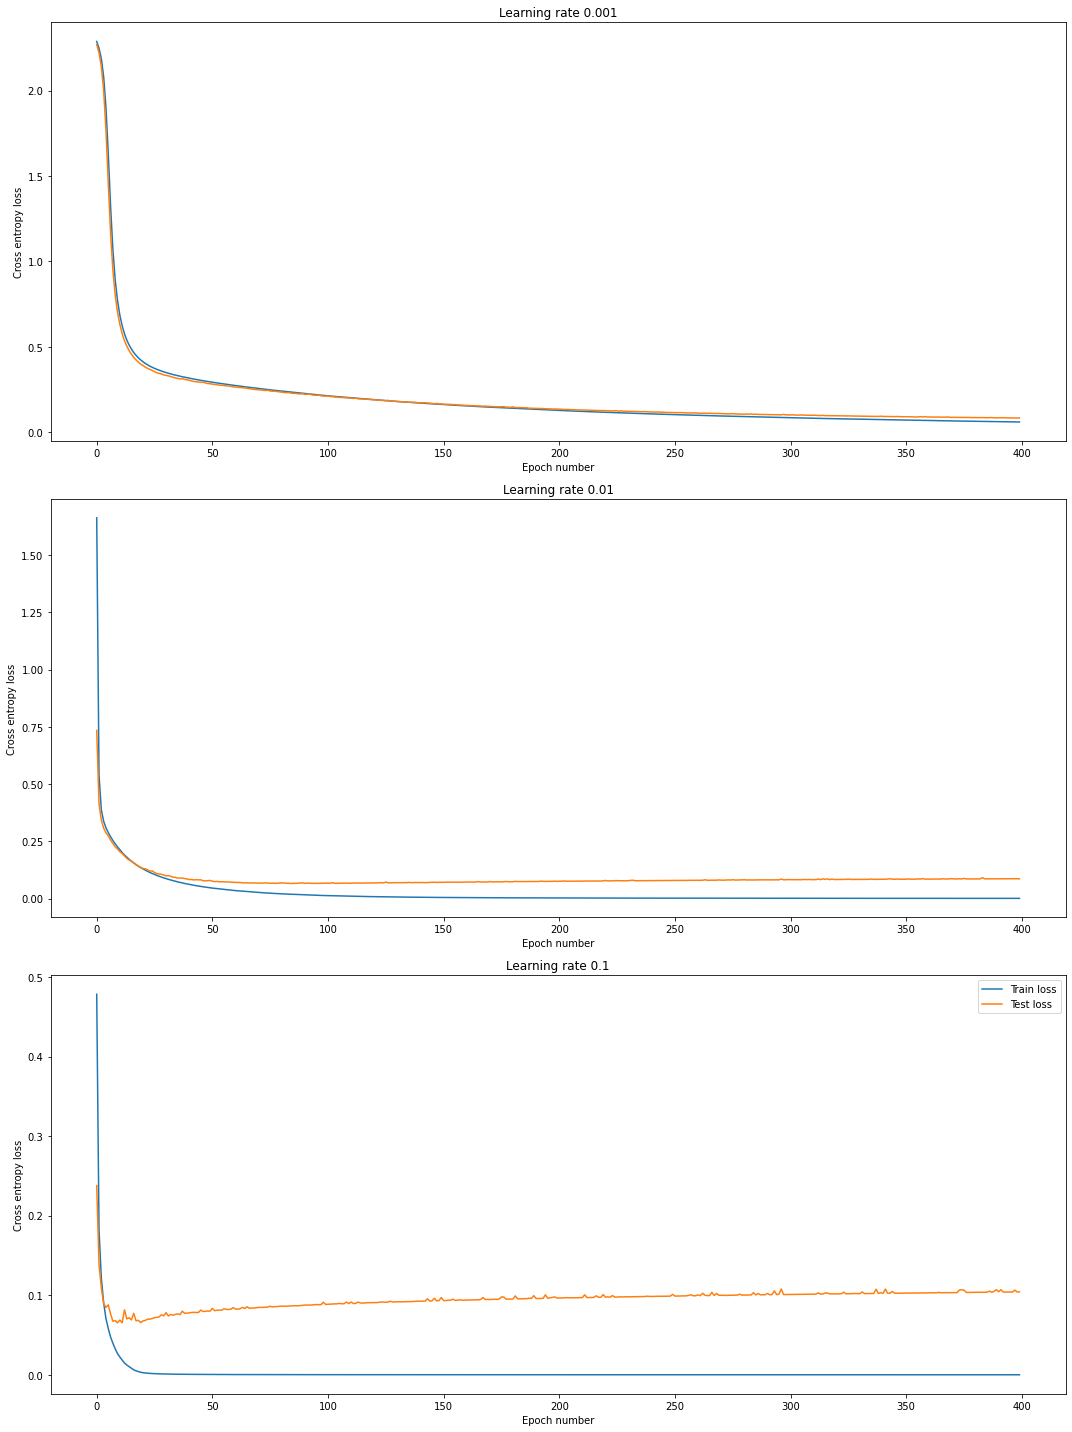

In [ ]:
figure, axis = plt.subplots(3, 1)
figure.set_size_inches(15, 20)

axis[0].plot(train_loss_lr_001_adam, label = 'Train loss')
axis[0].plot(test_loss_lr_001_adam, label = 'Test loss')
axis[0].set_title('Learning rate 0.001')

axis[1].plot(train_loss_lr_01_adam, label = 'Train loss')
axis[1].plot(test_loss_lr_01_adam, label = 'Test loss')
axis[1].set_title('Learning rate 0.01')

axis[2].plot(train_loss_lr_1_adam, label = 'Train loss')
axis[2].plot(test_loss_lr_1_adam, label = 'Test loss')
axis[2].set_title('Learning rate 0.1')

for i in range(3):
  axis[i].set_ylabel('Cross entropy loss')
  axis[i].set_xlabel('Epoch number')

plt.tight_layout()

plt.legend()
plt.show()

| Learning rate | Train loss | Test loss | Test Error |
| --- | --- | --- |--- |
| 0.001 | 0.06070128264777394 | 0.08503196069935134 | 0.0271
| 0.01 | 0.0006333929913308044 | 0.0867264796395795 | 0.0201
| 0.1 | 2.4558777324024424e-05 | 0.10417626639468691 | 0.0177

We observe that the larger the learning rate the more the training loss has converged. This is because in our case, the larger learning rate caused the optimizer to take larger steps towards minimum of the loss function, which helped the model converge faster. 

I also observe that the higher the learning rate the higher the test loss because the model is overfitting to the training data, hence doesnt ferform well on unseen data. This is confirmed by the history graphs because the test loss is at a higher point from it minimum at the end of 400 epochs. 


Although I dont observe the following for learning rate 0.1 (possibly because this value isn't large enough) for my specific example but when the learning rate is too large, the optimizer may overshoot the minimum of the loss function and start oscillating around it, leading to slower convergence or no convergence at all. This is because the optimizer takes larger steps towards the minimum, and if the learning rate is too high, the optimizer may overshoot the minimum and start moving back and forth around it. This oscillation slows down the optimization process, and the optimizer may get stuck in a suboptimal solution or fail to converge altogether. Our model doesnt have many parameters and isnt very deep (depth 1, width 256), hence the loss landscape isnt very non-convex hence a large learning rate of 0.1 works fine.

Another important comment is that from the graphs above, the generalisation error is the smallest for models with smaller learning rates because a smaller learning rate allows the model to converge more gradually and prevents overfitting.



###Task 8: Compare the performance for small and large batch size
I will now compare the performance of small and large batch sizes using the SGD optimizer with a fixed depth of 1, width of 64 and learning rate of 0.01. **Please note that I vary the epoch number for different batch sizes because larger batch sizes require very large epoch numbers to converge and repeating the sample number of epochs for smaller batch sizes will lead to extremely long run time for my code.**

In [ ]:
depth = 1
width = 64
learning_rate = 0.01

In [ ]:
batch_size = 8
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_batch_8, test_loss_batch_8, test_error_batch_8 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion, stopping_criteria=0.045)

Epoch: 0 | Train Loss: 0.5595945642079537 | Test Loss: 0.2752382971465588 | Test Error: 0.0772
Epoch: 1 | Train Loss: 0.22945733240634825 | Test Loss: 0.18096316546779126 | Test Error: 0.0536
Epoch: 2 | Train Loss: 0.16815676485490985 | Test Loss: 0.15250166889727115 | Test Error: 0.0474
Epoch: 3 | Train Loss: 0.1332046518044236 | Test Loss: 0.13144816569294782 | Test Error: 0.038
Epoch: 4 | Train Loss: 0.11153365347535195 | Test Loss: 0.11178884694830049 | Test Error: 0.0346
Epoch: 5 | Train Loss: 0.09456505241631724 | Test Loss: 0.10968241914220853 | Test Error: 0.0329
Epoch: 6 | Train Loss: 0.08294977024160617 | Test Loss: 0.10196478682139423 | Test Error: 0.032
Epoch: 7 | Train Loss: 0.07275342147031527 | Test Loss: 0.0965396559609857 | Test Error: 0.0301
Epoch: 8 | Train Loss: 0.06533064727641905 | Test Loss: 0.08935251936535933 | Test Error: 0.0279
Epoch: 9 | Train Loss: 0.0589537095458305 | Test Loss: 0.08807061902259593 | Test Error: 0.0275
Epoch: 10 | Train Loss: 0.05278596241

In [ ]:
print(train_loss_batch_8)
print(test_loss_batch_8)
print(test_error_batch_8)

[0.5595945642079537, 0.22945733240634825, 0.16815676485490985, 0.1332046518044236, 0.11153365347535195, 0.09456505241631724, 0.08294977024160617, 0.07275342147031527, 0.06533064727641905, 0.0589537095458305, 0.05278596241848427, 0.04700734542827389, 0.04358903861680198]
[0.2752382971465588, 0.18096316546779126, 0.15250166889727115, 0.13144816569294782, 0.11178884694830049, 0.10968241914220853, 0.10196478682139423, 0.0965396559609857, 0.08935251936535933, 0.08807061902259593, 0.09057644423167985, 0.09152694294009998, 0.08901445672133268]
[0.0772, 0.0536, 0.0474, 0.038, 0.0346, 0.0329, 0.032, 0.0301, 0.0279, 0.0275, 0.03, 0.0269, 0.0259]


In [ ]:
batch_size = 16
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_batch_16, test_loss_batch_16, test_error_batch_16 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion, stopping_criteria=0.045)

Epoch: 0 | Train Loss: 0.8219238838513693 | Test Loss: 0.32595634179115296 | Test Error: 0.0942
Epoch: 1 | Train Loss: 0.30344845309903223 | Test Loss: 0.2576600614219904 | Test Error: 0.0757
Epoch: 2 | Train Loss: 0.239633898434788 | Test Loss: 0.2095704131886363 | Test Error: 0.0615
Epoch: 3 | Train Loss: 0.19837230190100769 | Test Loss: 0.17756014686524868 | Test Error: 0.0527
Epoch: 4 | Train Loss: 0.16919460625785093 | Test Loss: 0.1533669189579785 | Test Error: 0.0466
Epoch: 5 | Train Loss: 0.14847384566261124 | Test Loss: 0.15215593744888903 | Test Error: 0.0454
Epoch: 6 | Train Loss: 0.1324075094292561 | Test Loss: 0.12880981255844234 | Test Error: 0.0403
Epoch: 7 | Train Loss: 0.11935582089548309 | Test Loss: 0.11846417939346283 | Test Error: 0.037
Epoch: 8 | Train Loss: 0.10780833032087733 | Test Loss: 0.11281931007821112 | Test Error: 0.0344
Epoch: 9 | Train Loss: 0.09890081898362066 | Test Loss: 0.10726323261596263 | Test Error: 0.0336
Epoch: 10 | Train Loss: 0.090382868453

In [ ]:
print(train_loss_batch_16)
print(test_loss_batch_16)
print(test_error_batch_16)

[0.8219238838513693, 0.30344845309903223, 0.239633898434788, 0.19837230190100769, 0.16919460625785093, 0.14847384566261124, 0.1324075094292561, 0.11935582089548309, 0.10780833032087733, 0.09890081898362066, 0.09038286845305314, 0.08387864790861495, 0.07800239326271693, 0.0720500317117044, 0.06761136348421375, 0.06315808537101063, 0.05914838901292533, 0.05514745509908535, 0.052590827755715386, 0.049162732202291955, 0.04647131008732055, 0.04388158153140879]
[0.32595634179115296, 0.2576600614219904, 0.2095704131886363, 0.17756014686524868, 0.1533669189579785, 0.15215593744888903, 0.12880981255844234, 0.11846417939346283, 0.11281931007821112, 0.10726323261596263, 0.1058832690436393, 0.1055456576006487, 0.10164243155866862, 0.0969277712428011, 0.0913156777688302, 0.08706740978304296, 0.09024657431780361, 0.08664466830703896, 0.08706212786664255, 0.08695641315844842, 0.08267895311154425, 0.0868587973518297]
[0.0942, 0.0757, 0.0615, 0.0527, 0.0466, 0.0454, 0.0403, 0.037, 0.0344, 0.0336, 0.033

In [ ]:
batch_size = 32
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_batch_32, test_loss_batch_32, test_error_batch_32 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion, stopping_criteria=0.045)

Epoch: 0 | Train Loss: 1.1905516098499298 | Test Loss: 0.4447280762675471 | Test Error: 0.1265
Epoch: 1 | Train Loss: 0.390859040927887 | Test Loss: 0.3324270918370245 | Test Error: 0.0952
Epoch: 2 | Train Loss: 0.3208154150366783 | Test Loss: 0.2914915276816287 | Test Error: 0.085
Epoch: 3 | Train Loss: 0.2837715569257736 | Test Loss: 0.2594370022654153 | Test Error: 0.0733
Epoch: 4 | Train Loss: 0.2565819522937139 | Test Loss: 0.2371830344557191 | Test Error: 0.0673
Epoch: 5 | Train Loss: 0.23447025011877218 | Test Loss: 0.22850419451205875 | Test Error: 0.0654
Epoch: 6 | Train Loss: 0.21495933661560218 | Test Loss: 0.20351791616898185 | Test Error: 0.0581
Epoch: 7 | Train Loss: 0.19764974224070708 | Test Loss: 0.19029929206227533 | Test Error: 0.0548
Epoch: 8 | Train Loss: 0.18238431002348662 | Test Loss: 0.17438646978416 | Test Error: 0.0509
Epoch: 9 | Train Loss: 0.16847468943993252 | Test Loss: 0.163803735265907 | Test Error: 0.0475
Epoch: 10 | Train Loss: 0.1563716576764981 | Te

In [ ]:
print(train_loss_batch_32)
print(test_loss_batch_32)
print(test_error_batch_32)

[1.1905516098499298, 0.390859040927887, 0.3208154150366783, 0.2837715569257736, 0.2565819522937139, 0.23447025011877218, 0.21495933661560218, 0.19764974224070708, 0.18238431002348662, 0.16847468943993252, 0.1563716576764981, 0.1461424992357691, 0.13683422997295858, 0.12895001297766964, 0.12149919951011737, 0.11492419773588577, 0.10906592582662901, 0.10310179819315672, 0.09854798778519035, 0.09381951882690191, 0.08946155032540361, 0.08547742509320379, 0.08187026598329346, 0.07833204382720092, 0.07513257919835548, 0.07183611967489123, 0.06918883967635532, 0.06649473096554478, 0.0636949651338781, 0.06124904669703295, 0.05907963611154506, 0.05685227417889983, 0.0548708337046206, 0.05278722375550618, 0.05118008010430882, 0.048887765978835526, 0.047417278173069156, 0.04539136109302441, 0.04387749834327648]
[0.4447280762675471, 0.3324270918370245, 0.2914915276816287, 0.2594370022654153, 0.2371830344557191, 0.22850419451205875, 0.20351791616898185, 0.19029929206227533, 0.17438646978416, 0.1638

In [ ]:
batch_size = 64
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_batch_64, test_loss_batch_64, test_error_batch_64 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion, stopping_criteria=0.045)

Epoch: 0 | Train Loss: 1.7950815625790595 | Test Loss: 0.8856719140034572 | Test Error: 0.2122
Epoch: 1 | Train Loss: 0.5996815385435944 | Test Loss: 0.4394206210116672 | Test Error: 0.1193
Epoch: 2 | Train Loss: 0.4070349152980329 | Test Loss: 0.3608850948749834 | Test Error: 0.1029
Epoch: 3 | Train Loss: 0.354602621189122 | Test Loss: 0.33207034533190877 | Test Error: 0.0969
Epoch: 4 | Train Loss: 0.32453334054300015 | Test Loss: 0.2999319589346837 | Test Error: 0.0872
Epoch: 5 | Train Loss: 0.3007925275697319 | Test Loss: 0.2798988915932406 | Test Error: 0.0814
Epoch: 6 | Train Loss: 0.2808243715083167 | Test Loss: 0.26332132674896036 | Test Error: 0.0761
Epoch: 7 | Train Loss: 0.26329168857240093 | Test Loss: 0.24664000179737236 | Test Error: 0.0711
Epoch: 8 | Train Loss: 0.24748291956113855 | Test Loss: 0.23305956682391987 | Test Error: 0.067
Epoch: 9 | Train Loss: 0.23314123350912447 | Test Loss: 0.21995784892777728 | Test Error: 0.0634
Epoch: 10 | Train Loss: 0.22025839478047546

In [ ]:
print(train_loss_batch_64)
print(test_loss_batch_64)
print(test_error_batch_64)

[1.7950815625790595, 0.5996815385435944, 0.4070349152980329, 0.354602621189122, 0.32453334054300015, 0.3007925275697319, 0.2808243715083167, 0.26329168857240093, 0.24748291956113855, 0.23314123350912447, 0.22025839478047546, 0.2087446624226471, 0.19818822383435805, 0.18862687562828634, 0.17963364336695245, 0.17200215627500878, 0.16462450571207285, 0.15826242525718295, 0.15175309209530352, 0.1461169679265922, 0.14088045379150904, 0.135551996958027, 0.13091626465479447, 0.12669324091693232, 0.12262623352624143, 0.11885658423426246, 0.11538316578920017, 0.11220448937660246, 0.10895208609022343, 0.1061359101227288, 0.10294073496832014, 0.1003595934197831, 0.09779836996289681, 0.09552628541740575, 0.0931112563628743, 0.09069433785986894, 0.08865008320508481, 0.08662854281784312, 0.08471733189698284, 0.08282069679099455, 0.08079981117713839, 0.07912155618416523, 0.07727731968750799, 0.07550051577214494, 0.0739897720506792, 0.07236722545392478, 0.07081758062929105, 0.06927064237351627, 0.0679

In [ ]:
batch_size = 128
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_batch_128, test_loss_batch_128, test_error_batch_128 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion, stopping_criteria=0.045)

Epoch: 0 | Train Loss: 2.2127870494114563 | Test Loss: 1.9965843324419819 | Test Error: 0.465
Epoch: 1 | Train Loss: 1.4170243897671893 | Test Loss: 0.8938499470300312 | Test Error: 0.2062
Epoch: 2 | Train Loss: 0.7035096069770073 | Test Loss: 0.5509260911730272 | Test Error: 0.1438
Epoch: 3 | Train Loss: 0.5022382925568359 | Test Loss: 0.43644790709773196 | Test Error: 0.1198
Epoch: 4 | Train Loss: 0.4260342554179336 | Test Loss: 0.3905507118641576 | Test Error: 0.1099
Epoch: 5 | Train Loss: 0.3865020292908398 | Test Loss: 0.3602680422459977 | Test Error: 0.1046
Epoch: 6 | Train Loss: 0.3610744784826409 | Test Loss: 0.34845991262906717 | Test Error: 0.0982
Epoch: 7 | Train Loss: 0.3430125831540968 | Test Loss: 0.3202632554347002 | Test Error: 0.0935
Epoch: 8 | Train Loss: 0.32837285415958495 | Test Loss: 0.3201252471042585 | Test Error: 0.0899
Epoch: 9 | Train Loss: 0.31641655798151547 | Test Loss: 0.2980215159963958 | Test Error: 0.086
Epoch: 10 | Train Loss: 0.30577266508582307 | Te

In [ ]:
print(train_loss_batch_128)
print(test_loss_batch_128)
print(test_error_batch_128)

[2.2127870494114563, 1.4170243897671893, 0.7035096069770073, 0.5022382925568359, 0.4260342554179336, 0.3865020292908398, 0.3610744784826409, 0.3430125831540968, 0.32837285415958495, 0.31641655798151547, 0.30577266508582307, 0.2964619488032388, 0.2879895544064833, 0.27994338588229123, 0.2723109454138955, 0.26469803965295047, 0.2577211833807197, 0.2506318372100401, 0.2440085840631904, 0.2374956672633889, 0.23142178834819083, 0.22520657361888174, 0.21990957331937006, 0.214388134986607, 0.20923412997903093, 0.20431492596801157, 0.19966373381330005, 0.19507808084172734, 0.19044888442926317, 0.18650306907416916, 0.1821871437052928, 0.17841491768799866, 0.1745198137804008, 0.17104012523092696, 0.1671488256231427, 0.16376618574709018, 0.1607243231714153, 0.15742048899184413, 0.15436911097626443, 0.1512731352546957, 0.1484899519047122, 0.14559512037331107, 0.1431031649682059, 0.14036200365929336, 0.13764111315215954, 0.13554124753358268, 0.13320975042164707, 0.13063660346622916, 0.1285127257979

In [ ]:
batch_size = 256
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_batch_256, test_loss_batch_256, test_error_batch_256 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion, stopping_criteria=0.045)

Epoch: 0 | Train Loss: 2.272352815181651 | Test Loss: 2.218308287858963 | Test Error: 0.8072
Epoch: 1 | Train Loss: 2.096698900993834 | Test Loss: 1.9090067565441131 | Test Error: 0.5109
Epoch: 2 | Train Loss: 1.6281240331365707 | Test Loss: 1.2830048620700836 | Test Error: 0.2824
Epoch: 3 | Train Loss: 1.0397321680758862 | Test Loss: 0.8264874383807183 | Test Error: 0.2025
Epoch: 4 | Train Loss: 0.7357926389004322 | Test Loss: 0.6372028008103371 | Test Error: 0.1672
Epoch: 5 | Train Loss: 0.5999507226842515 | Test Loss: 0.5337548203766346 | Test Error: 0.143
Epoch: 6 | Train Loss: 0.5221775978169543 | Test Loss: 0.4780708059668541 | Test Error: 0.1264
Epoch: 7 | Train Loss: 0.47106431481686045 | Test Loss: 0.4346802681684494 | Test Error: 0.1191
Epoch: 8 | Train Loss: 0.4361943886635151 | Test Loss: 0.4096890538930893 | Test Error: 0.1132
Epoch: 9 | Train Loss: 0.4111060531849557 | Test Loss: 0.38393406122922896 | Test Error: 0.1072
Epoch: 10 | Train Loss: 0.3926494398015611 | Test Lo

In [ ]:
print(train_loss_batch_256)
print(test_loss_batch_256)
print(test_error_batch_256)

[2.272352815181651, 2.096698900993834, 1.6281240331365707, 1.0397321680758862, 0.7357926389004322, 0.5999507226842515, 0.5221775978169543, 0.47106431481686045, 0.4361943886635151, 0.4111060531849557, 0.3926494398015611, 0.3775973830451357, 0.3651938957736847, 0.3549008422709526, 0.345296532676575, 0.33768500115009065, 0.3304404175027888, 0.32354993940667903, 0.31768144939808135, 0.3121466857955811, 0.30664266290816855, 0.30183818511506344, 0.2969152732732448, 0.29288920582608974, 0.28868745362505, 0.28432823026433907, 0.2804021383219577, 0.27597741801688014, 0.27244992763438125, 0.2689483588680308, 0.26519193750746706, 0.2621002212483832, 0.2586933305922975, 0.2548930178931419, 0.2516510102977144, 0.24827913312201805, 0.2453956221012359, 0.2421325957521479, 0.23918330444300429, 0.23601341415592964, 0.2331715837438056, 0.23077699941523533, 0.2278856158256531, 0.22483844411499956, 0.22260619883841656, 0.21971519329446426, 0.21713486881332195, 0.21473918106961756, 0.2120120720343387, 0.20

In [ ]:
batch_size = 512
train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.SGD(net_mnist.parameters(), lr=learning_rate)
train_loss_batch_512, test_loss_batch_512, test_error_batch_512 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion, stopping_criteria=0.045)

Epoch: 0 | Train Loss: 2.284902364520703 | Test Loss: 2.261999213695526 | Test Error: 0.8537
Epoch: 1 | Train Loss: 2.2329039452439647 | Test Loss: 2.1934489727020265 | Test Error: 0.6932
Epoch: 2 | Train Loss: 2.137987280296067 | Test Loss: 2.059847378730774 | Test Error: 0.5054
Epoch: 3 | Train Loss: 1.9568532836639274 | Test Loss: 1.8177029609680175 | Test Error: 0.4268
Epoch: 4 | Train Loss: 1.6652101561174555 | Test Loss: 1.4750522553920746 | Test Error: 0.3411
Epoch: 5 | Train Loss: 1.3210215396800284 | Test Loss: 1.1505084455013275 | Test Error: 0.2579
Epoch: 6 | Train Loss: 1.0485500723628673 | Test Loss: 0.9312972784042358 | Test Error: 0.2175
Epoch: 7 | Train Loss: 0.8699310134022923 | Test Loss: 0.7867644727230072 | Test Error: 0.1902
Epoch: 8 | Train Loss: 0.7515153990963758 | Test Loss: 0.6872446358203887 | Test Error: 0.1694
Epoch: 9 | Train Loss: 0.6670298389459061 | Test Loss: 0.6164327472448349 | Test Error: 0.1581
Epoch: 10 | Train Loss: 0.603897568027852 | Test Loss:

In [ ]:
print(train_loss_batch_512)
print(test_loss_batch_512)
print(test_error_batch_512)

[2.284902364520703, 2.2329039452439647, 2.137987280296067, 1.9568532836639274, 1.6652101561174555, 1.3210215396800284, 1.0485500723628673, 0.8699310134022923, 0.7515153990963758, 0.6670298389459061, 0.603897568027852, 0.5569798888291343, 0.5212658413891065, 0.491268515586853, 0.46844646460929157, 0.44956330348879603, 0.43328400638143894, 0.4190669979079295, 0.4084988640526594, 0.3982932645890672, 0.3886066101870294, 0.3820649549617606, 0.37549399344597834, 0.3676303847361419, 0.36132349604267183, 0.35574109751289174, 0.35055638597173205, 0.3463276173856299, 0.3423348256086899, 0.33771651402368386, 0.333466280820006, 0.33083744220814465, 0.3283435815976838, 0.3227965057653896, 0.3199496081067344, 0.3174066508220414, 0.31454848308684463, 0.31100287099005813, 0.30876375015004204, 0.306951954834542, 0.3037451965323949, 0.30157781139773837, 0.2986144427273233, 0.2968492545818878, 0.2954473518213983, 0.29263013197203813, 0.29065596905805297, 0.2887411943431628, 0.2862765580668288, 0.28469638

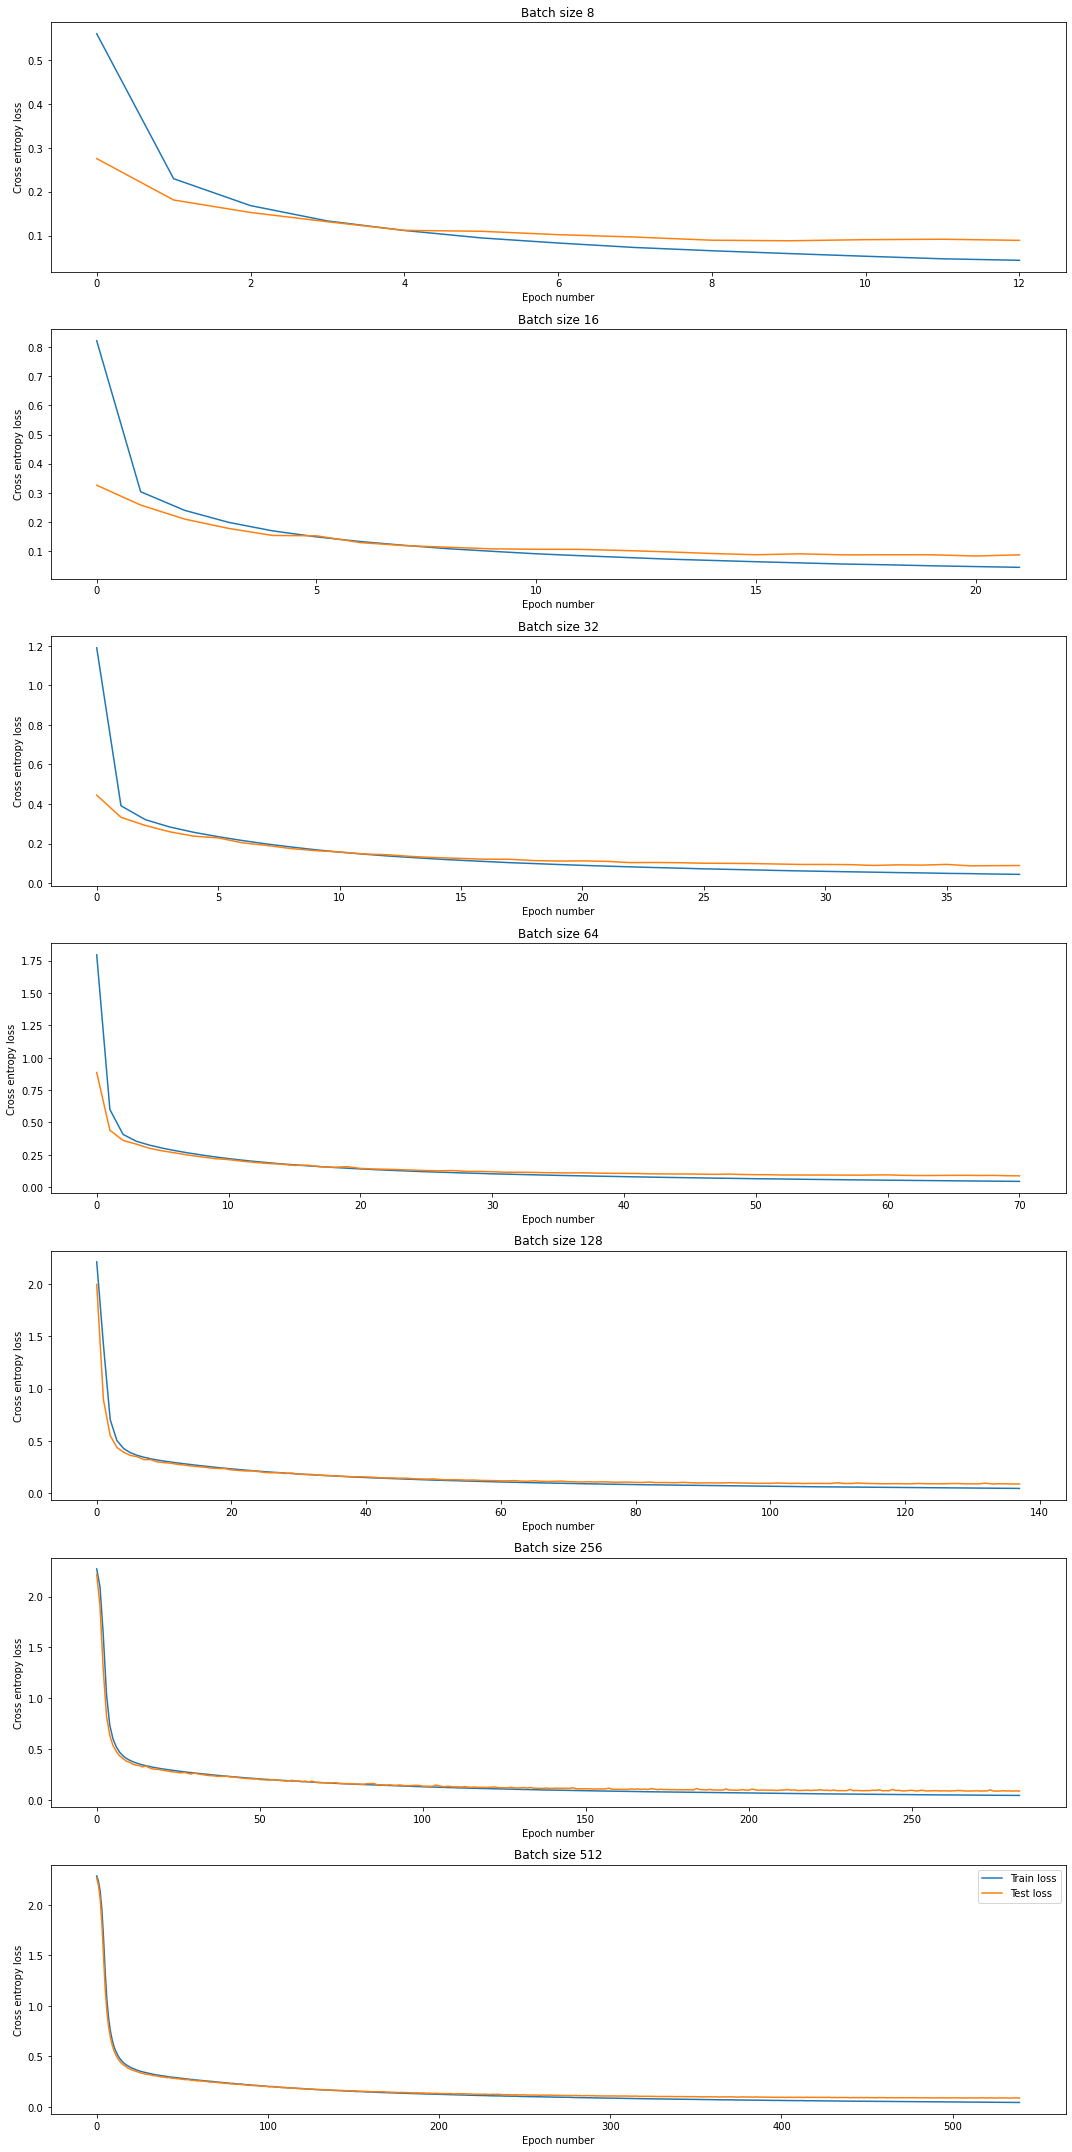

In [ ]:
figure, axis = plt.subplots(7, 1)
figure.set_size_inches(15, 30)

axis[0].plot(train_loss_batch_8, label = 'Train loss')
axis[0].plot(test_loss_batch_8, label = 'Test loss')
axis[0].set_title('Batch size 8')

axis[1].plot(train_loss_batch_16, label = 'Train loss')
axis[1].plot(test_loss_batch_16, label = 'Test loss')
axis[1].set_title('Batch size 16')

axis[2].plot(train_loss_batch_32, label = 'Train loss')
axis[2].plot(test_loss_batch_32, label = 'Test loss')
axis[2].set_title('Batch size 32')

axis[3].plot(train_loss_batch_64, label = 'Train loss')
axis[3].plot(test_loss_batch_64, label = 'Test loss')
axis[3].set_title('Batch size 64')

axis[4].plot(train_loss_batch_128, label = 'Train loss')
axis[4].plot(test_loss_batch_128, label = 'Test loss')
axis[4].set_title('Batch size 128')

axis[5].plot(train_loss_batch_256, label = 'Train loss')
axis[5].plot(test_loss_batch_256, label = 'Test loss')
axis[5].set_title('Batch size 256')

axis[6].plot(train_loss_batch_512, label = 'Train loss')
axis[6].plot(test_loss_batch_512, label = 'Test loss')
axis[6].set_title('Batch size 512')

for i in range(7):
  axis[i].set_ylabel('Cross entropy loss')
  axis[i].set_xlabel('Epoch number')

plt.tight_layout()

plt.legend()
plt.show()

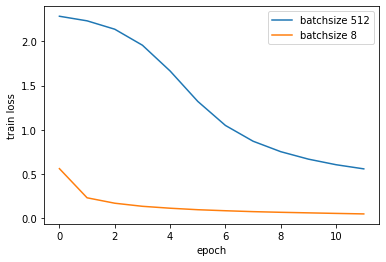

In [ ]:
plt.plot(train_loss_batch_512[:12], label='batchsize 512')
plt.plot(train_loss_batch_8[:12], label='batchsize 8')
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.legend()
plt.show()

I noticed that the train loss converges after more epochs for larger batch sizes. I think this because with larger batch sizes there are fewer updates to the model (the optimizer updates the weights fewer times) and smaller updates to the model (as the optimizer takes an average of a larger batch size so less variance is found) for each epoch, hence the model parameters need more epochs to converge to optimal values relative to a model using smaller batch sizes.

One trade-off I noticed was that my tablet laptop had memory issues for the largest batch size, this is because larger batch sizes require more memory to store the intermediate computations during backpropagation, which could become a limiting factor on some hardware or for very large datasets.

I also noticed that using a larger batchsize helped smooth out the optimisation trajectory by reducing the variance in the gradient estimates. This is evident in my graph of comparing train loss of batch size 8 and batchsize 512 for the first 12 epochs.


In [ ]:
#calculating generalisation errors where each experiment has a similar train loss
generalisation_error_batch_8 = np.abs(np.array(train_loss_batch_8)-np.array(test_loss_batch_8))
generalisation_error_batch_16 = np.abs(np.array(train_loss_batch_16)-np.array(test_loss_batch_16))
generalisation_error_batch_32 = np.abs(np.array(train_loss_batch_32)-np.array(test_loss_batch_32))
generalisation_error_batch_64 = np.abs(np.array(train_loss_batch_64)-np.array(test_loss_batch_64))
generalisation_error_batch_128 = np.abs(np.array(train_loss_batch_128)-np.array(test_loss_batch_128))
generalisation_error_batch_256 = np.abs(np.array(train_loss_batch_256)-np.array(test_loss_batch_256))
generalisation_error_batch_512 = np.abs(np.array(train_loss_batch_512)-np.array(test_loss_batch_512))

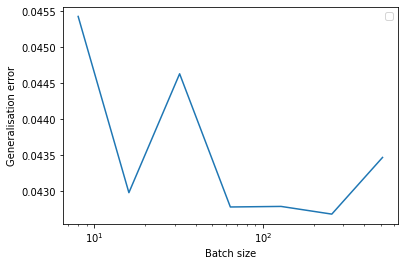

In [ ]:
y_axis = [generalisation_error_batch_8[-1],generalisation_error_batch_16[-1],generalisation_error_batch_32[-1],generalisation_error_batch_64[-1],
          generalisation_error_batch_128[-1],generalisation_error_batch_256[-1],generalisation_error_batch_512[-1]]

plt.plot([8, 16, 32, 64, 128, 256, 512], y_axis)
plt.xlabel('Batch size')
plt.xscale('log')
plt.ylabel('Generalisation error')

plt.legend()
plt.show();

I would have expected that the generalisation error increases as the batch size increases (for a similar training loss) but as you can see I don't get a clear increasing pattern in the above graph.

I have a very high generalization error for a really small batch size of 8 which quickly drops as we increase the batch size to 16. The high generalisation error at a really small batch size of 8 could be because the network is being trained on a limited number of examples at a time, which can lead to high variance in the estimates of the gradients used to update the weights.   

We would expect smaller generalisation error for smaller batches because each batch contains a smaller number of examples, and as a result, the gradients computed on each batch will have more variability due to the random sampling of the data. This increased variability can be thought of as adding noise to the training process. This can help regularise the model and prevent it from overfitting, leading to a smaller generalization error. This is confirmed by Keskar et al. (2016), where the author found that as the batch size increases, the model's generalization gap also increases, leading to worse performance on the test set. They attribute this to the fact that large batch sizes lead to sharp minimizers in the training loss landscape, which generalize poorly to unseen data.

The paper suggests that adding noise to the training process, such as through the use of dropout or stochastic gradient descent, can help mitigate the negative effects of large batch sizes on generalization performance.

I don't get increasing generalisation error as I increase the batch size possibly because of the overfitting effect in the models or because the MNIST dataset is already quite noisy (contains some inconsistent data).

**Note: for this experiment my graphs and tables have values until the epoch number where the experiment for each batch size has converged to a similar train loss (approimately 0.019).**

| Batch size | Train loss | Test loss | 
| --- | --- | --- | 
| 8 | 0.04358903861680198 | 0.08901445672133268
| 16 | 0.04388158153140879 | 0.0868587973518297
| 32 | 0.04387749834327648 | 0.08850624165259682
| 64 | 0.04428654810242943 | 0.08706484390289232
| 128 | 0.044541494186117706 | 0.08732760602702634
| 256 | 0.04483347711886497 | 0.08751265613827855
| 512 | 0.044671106420583646 | 0.08813765160739422


My results don't show that the test loss increases for larger batch sizes for similar train loss unlike in [Keskar et al., 2016]. This is a direct result of not getting the desired generalization error pattern.

###Task 9: Analyse the train and test errors as a function of width
In this task I will investigate the effect of varying the width of the neural network. I am using a neural network with depth 1 and learning rate 0.001. The experiment will be ran for 100 epochs using batchsize 64 and Adam optimizer.

In [ ]:
epoch_limit = 100
depth = 1
learning_rate = 0.001
batch_size = 64

train_set_mnist, test_set_mnist = loading_data(batch_size, mnist_train, mnist_test)

In [ ]:
width = 4
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_4, test_loss_width_4, test_error_width_4 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 1.7831705616735447 | Test Loss: 1.4348526114870788 | Test Error: 0.5312
Epoch: 1 | Train Loss: 1.2756748266819953 | Test Loss: 1.1571075570811131 | Test Error: 0.3858
Epoch: 2 | Train Loss: 1.0879985139822401 | Test Loss: 0.9936348579491779 | Test Error: 0.2771
Epoch: 3 | Train Loss: 0.9170553794166426 | Test Loss: 0.8294553635226694 | Test Error: 0.2487
Epoch: 4 | Train Loss: 0.7871259161785468 | Test Loss: 0.7499978796691652 | Test Error: 0.2255
Epoch: 5 | Train Loss: 0.7199195925869158 | Test Loss: 0.6929842945496747 | Test Error: 0.2111
Epoch: 6 | Train Loss: 0.6720474689626998 | Test Loss: 0.6650942953149225 | Test Error: 0.2006
Epoch: 7 | Train Loss: 0.6466266612953214 | Test Loss: 0.644057863267364 | Test Error: 0.1933
Epoch: 8 | Train Loss: 0.6302946468215507 | Test Loss: 0.6422270940747231 | Test Error: 0.1878
Epoch: 9 | Train Loss: 0.6198859925209078 | Test Loss: 0.6230525385801959 | Test Error: 0.187
Epoch: 10 | Train Loss: 0.6107808795056617 | Test Lo

In [ ]:
print(train_loss_width_4)
print(test_loss_width_4)
print(test_error_width_4)

[1.7831705616735447, 1.2756748266819953, 1.0879985139822401, 0.9170553794166426, 0.7871259161785468, 0.7199195925869158, 0.6720474689626998, 0.6466266612953214, 0.6302946468215507, 0.6198859925209078, 0.6107808795056617, 0.6046162167274113, 0.5984784437776375, 0.5944209222727493, 0.5902458925618291, 0.5867754330735471, 0.583969379475376, 0.5805147262587984, 0.5788512865363408, 0.5761099641225231, 0.5738362761448695, 0.5721758020870975, 0.5696844513545921, 0.5669116862197675, 0.5657011754413658, 0.5644198688172074, 0.5620989461919901, 0.5606956547384323, 0.5581216559544809, 0.5572096304153837, 0.5551264531481495, 0.5534359180310896, 0.5519232411882771, 0.5507570623811374, 0.5474191303096855, 0.5451190961576474, 0.542799650145365, 0.5412747594974697, 0.5388808202610087, 0.5365564112247688, 0.5353617155348568, 0.5331819039513307, 0.5317873997347695, 0.5299750393800644, 0.5286692273673981, 0.5271168123049014, 0.5256098760311791, 0.5250953311350808, 0.5240893809081141, 0.5224759719296813, 0

In [ ]:
width = 8
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_8, test_loss_width_8, test_error_width_8 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.9534795391978994 | Test Loss: 0.5139778251670728 | Test Error: 0.1452
Epoch: 1 | Train Loss: 0.4925391753313384 | Test Loss: 0.4527162655143981 | Test Error: 0.1215
Epoch: 2 | Train Loss: 0.4305284859529182 | Test Loss: 0.4042583613828489 | Test Error: 0.1112
Epoch: 3 | Train Loss: 0.38909190370520547 | Test Loss: 0.37513547765601213 | Test Error: 0.1064
Epoch: 4 | Train Loss: 0.36183684193757554 | Test Loss: 0.36393130898096 | Test Error: 0.1013
Epoch: 5 | Train Loss: 0.34426360516183413 | Test Loss: 0.34327556501338435 | Test Error: 0.0969
Epoch: 6 | Train Loss: 0.3307773257528287 | Test Loss: 0.33717713599941534 | Test Error: 0.0969
Epoch: 7 | Train Loss: 0.32293904598143053 | Test Loss: 0.32888130815165817 | Test Error: 0.0935
Epoch: 8 | Train Loss: 0.3160244609310683 | Test Loss: 0.3241355360313586 | Test Error: 0.0921
Epoch: 9 | Train Loss: 0.3100574940903736 | Test Loss: 0.3214766377001811 | Test Error: 0.0888
Epoch: 10 | Train Loss: 0.3052949482825265 |

In [ ]:
print(train_loss_width_8)
print(test_loss_width_8)
print(test_error_width_8)

[0.9534795391978994, 0.4925391753313384, 0.4305284859529182, 0.38909190370520547, 0.36183684193757554, 0.34426360516183413, 0.3307773257528287, 0.32293904598143053, 0.3160244609310683, 0.3100574940903736, 0.3052949482825265, 0.3010155492658808, 0.29749722798654776, 0.293835671090368, 0.2911929809001844, 0.2884030309058964, 0.28659169611010726, 0.2841382755844324, 0.2830294144671482, 0.2809175235876587, 0.27981213537424104, 0.2784285483631625, 0.276708890884511, 0.27581617511761214, 0.2743311733293381, 0.2727786137509956, 0.2723788508712483, 0.2712630340611058, 0.26965983977307006, 0.26862399988194136, 0.26876077214394933, 0.26685168289903133, 0.2662326728365124, 0.2653390258741277, 0.2651746302549201, 0.26367691635037027, 0.26347144381768667, 0.26319376265665867, 0.26163592257463475, 0.2607697975883352, 0.2607395385167619, 0.2597657688605442, 0.2582457316225208, 0.25818375300274476, 0.2573250160018391, 0.25741682570181423, 0.2566708471141517, 0.25677652328984063, 0.2551778363965468, 0.

In [ ]:
width = 16
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_16, test_loss_width_16, test_error_width_16 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.595232540840851 | Test Loss: 0.3206110466627558 | Test Error: 0.0931
Epoch: 1 | Train Loss: 0.29426415064441624 | Test Loss: 0.25751554382264996 | Test Error: 0.0743
Epoch: 2 | Train Loss: 0.24542324781529049 | Test Loss: 0.233164478544217 | Test Error: 0.0701
Epoch: 3 | Train Loss: 0.21565002722065968 | Test Loss: 0.21500967673150598 | Test Error: 0.0597
Epoch: 4 | Train Loss: 0.19960415313866284 | Test Loss: 0.20376929365525578 | Test Error: 0.0592
Epoch: 5 | Train Loss: 0.18401516946767377 | Test Loss: 0.21034488902919612 | Test Error: 0.0603
Epoch: 6 | Train Loss: 0.17468631386693353 | Test Loss: 0.19002764191549676 | Test Error: 0.0552
Epoch: 7 | Train Loss: 0.16630327694618435 | Test Loss: 0.1876035232310462 | Test Error: 0.053
Epoch: 8 | Train Loss: 0.15832576462065678 | Test Loss: 0.1732457309818951 | Test Error: 0.0498
Epoch: 9 | Train Loss: 0.152855013687807 | Test Loss: 0.17629626095532233 | Test Error: 0.0501
Epoch: 10 | Train Loss: 0.14774500382150

In [ ]:
print(train_loss_width_16)
print(test_loss_width_16)
print(test_error_width_16)

[0.595232540840851, 0.29426415064441624, 0.24542324781529049, 0.21565002722065968, 0.19960415313866284, 0.18401516946767377, 0.17468631386693353, 0.16630327694618435, 0.15832576462065678, 0.152855013687807, 0.147745003821507, 0.14196475567832303, 0.13768273723452712, 0.13485510282115196, 0.13158676318570114, 0.12722913934581126, 0.12443561849396811, 0.121566989896958, 0.11921723009144733, 0.1161614759072566, 0.11567163395423338, 0.11193692933684632, 0.10989816782416216, 0.10812282773540981, 0.10714182800857593, 0.10435940386918086, 0.10222578166561054, 0.10097448757516025, 0.1002127766750181, 0.09722992973124135, 0.09650927692848339, 0.09525650190010762, 0.093598645182946, 0.09251705871950557, 0.09154361968776628, 0.09088151561501406, 0.08885530472995201, 0.08808852764375723, 0.08666103302604401, 0.08528886979241282, 0.08393276526308707, 0.08384760676511824, 0.08396756397619812, 0.08149962019778963, 0.08174921602243061, 0.08044790560670043, 0.07995828487145812, 0.0793033534393354, 0.07

In [ ]:
width = 32
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_32, test_loss_width_32, test_error_width_32 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.47057583596883046 | Test Loss: 0.23063285406797554 | Test Error: 0.0691
Epoch: 1 | Train Loss: 0.20640408422059214 | Test Loss: 0.17783706794214096 | Test Error: 0.0547
Epoch: 2 | Train Loss: 0.161443208066274 | Test Loss: 0.1664288493620742 | Test Error: 0.0554
Epoch: 3 | Train Loss: 0.13566521592815517 | Test Loss: 0.13522360888517396 | Test Error: 0.041
Epoch: 4 | Train Loss: 0.11605414550112032 | Test Loss: 0.12155158497440587 | Test Error: 0.0379
Epoch: 5 | Train Loss: 0.10240448137788948 | Test Loss: 0.12048370714423953 | Test Error: 0.0362
Epoch: 6 | Train Loss: 0.09284853097150671 | Test Loss: 0.11163893702164127 | Test Error: 0.0331
Epoch: 7 | Train Loss: 0.08332504803485581 | Test Loss: 0.11563202744693893 | Test Error: 0.0339
Epoch: 8 | Train Loss: 0.07713031598569345 | Test Loss: 0.10252161674604864 | Test Error: 0.0309
Epoch: 9 | Train Loss: 0.07060933736031816 | Test Loss: 0.10847078754409412 | Test Error: 0.032
Epoch: 10 | Train Loss: 0.065350087

In [ ]:
print(train_loss_width_32)
print(test_loss_width_32)
print(test_error_width_32)

[0.47057583596883046, 0.20640408422059214, 0.161443208066274, 0.13566521592815517, 0.11605414550112032, 0.10240448137788948, 0.09284853097150671, 0.08332504803485581, 0.07713031598569345, 0.07060933736031816, 0.06535008712026324, 0.060263979090337975, 0.057199150639107584, 0.0526226015525313, 0.04982819220772001, 0.04707755414105809, 0.04338212030133538, 0.04242749071952059, 0.03956838761297946, 0.035485995511438995, 0.034504761560980146, 0.03340632298673098, 0.0299241517848923, 0.028464883722591774, 0.028264251439542976, 0.02522053127775891, 0.023550647569372, 0.023509538749348063, 0.021563729059064327, 0.021233740090701565, 0.01987043275757368, 0.01894743015424898, 0.017109818241724903, 0.01655355497191357, 0.016965500793411338, 0.015192079724602663, 0.014882001614173173, 0.014644119096527396, 0.013904169820827969, 0.012321534525543453, 0.013321907148930088, 0.012517751116048166, 0.011848953619447246, 0.011306767180812381, 0.009266202345533025, 0.010114418356925971, 0.011659712641939

In [ ]:
width = 64
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_64, test_loss_width_64, test_error_width_64 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.37870784672195595 | Test Loss: 0.193208005018295 | Test Error: 0.0557
Epoch: 1 | Train Loss: 0.17203265869978077 | Test Loss: 0.14967305522862892 | Test Error: 0.0464
Epoch: 2 | Train Loss: 0.12678320529554954 | Test Loss: 0.12300306862326944 | Test Error: 0.035
Epoch: 3 | Train Loss: 0.09999777476337038 | Test Loss: 0.10562388336724916 | Test Error: 0.031
Epoch: 4 | Train Loss: 0.08149639072506301 | Test Loss: 0.10382667931900093 | Test Error: 0.0303
Epoch: 5 | Train Loss: 0.06849663277769259 | Test Loss: 0.08578382582540155 | Test Error: 0.0263
Epoch: 6 | Train Loss: 0.057948316688706945 | Test Loss: 0.09765869010666943 | Test Error: 0.0282
Epoch: 7 | Train Loss: 0.05053018960880358 | Test Loss: 0.09157645359418835 | Test Error: 0.0271
Epoch: 8 | Train Loss: 0.043498199278943495 | Test Loss: 0.08546833613009494 | Test Error: 0.0258
Epoch: 9 | Train Loss: 0.03849894910916013 | Test Loss: 0.09695958056647307 | Test Error: 0.0292
Epoch: 10 | Train Loss: 0.032844

In [ ]:
print(train_loss_width_64)
print(test_loss_width_64)
print(test_error_width_64)

[0.37870784672195595, 0.17203265869978077, 0.12678320529554954, 0.09999777476337038, 0.08149639072506301, 0.06849663277769259, 0.057948316688706945, 0.05053018960880358, 0.043498199278943495, 0.03849894910916013, 0.032844533246365, 0.02853723221078966, 0.02656000539247043, 0.022600887931011088, 0.021168386879953434, 0.0189038053977051, 0.016350911227228027, 0.014570578956606808, 0.014343557399146552, 0.013356461658288398, 0.01285432839254361, 0.009055052557125512, 0.012841884339799598, 0.009619066563957107, 0.011967083896262672, 0.0070733356177773345, 0.010013620291778864, 0.008042064582462023, 0.01011004552683536, 0.008265848220210294, 0.004816951065836806, 0.009845517841500886, 0.005114148396843907, 0.008942290787249884, 0.005994415983263595, 0.006621529229086184, 0.006970845003302902, 0.009507004840507234, 0.004384927583232774, 0.004261561186788651, 0.008445751750357727, 0.006490178946082081, 0.0066332062285949355, 0.006265349617849324, 0.006628522738545382, 0.004554236404040856, 0.

In [ ]:
width = 128
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_128, test_loss_width_128, test_error_width_128 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.3257516462073874 | Test Loss: 0.15849274456216272 | Test Error: 0.0478
Epoch: 1 | Train Loss: 0.13269543251805088 | Test Loss: 0.1047806666606361 | Test Error: 0.0329
Epoch: 2 | Train Loss: 0.08891105942968239 | Test Loss: 0.08657702869160255 | Test Error: 0.0278
Epoch: 3 | Train Loss: 0.06966120170539558 | Test Loss: 0.0758995562999444 | Test Error: 0.0228
Epoch: 4 | Train Loss: 0.054437646574935494 | Test Loss: 0.08218724311738732 | Test Error: 0.0263
Epoch: 5 | Train Loss: 0.0442010851611427 | Test Loss: 0.07450028400865212 | Test Error: 0.0237
Epoch: 6 | Train Loss: 0.03479753891552507 | Test Loss: 0.0817997642313753 | Test Error: 0.025
Epoch: 7 | Train Loss: 0.03013080863434988 | Test Loss: 0.1029655374638487 | Test Error: 0.0284
Epoch: 8 | Train Loss: 0.023316981284406287 | Test Loss: 0.08037992549139211 | Test Error: 0.0218
Epoch: 9 | Train Loss: 0.02157612551657569 | Test Loss: 0.08697601570673642 | Test Error: 0.0241
Epoch: 10 | Train Loss: 0.017460569

In [ ]:
print(train_loss_width_128)
print(test_loss_width_128)
print(test_error_width_128)

[0.3257516462073874, 0.13269543251805088, 0.08891105942968239, 0.06966120170539558, 0.054437646574935494, 0.0442010851611427, 0.03479753891552507, 0.03013080863434988, 0.023316981284406287, 0.02157612551657569, 0.01746056932900255, 0.016447055203782302, 0.014512114234989963, 0.01463465441786833, 0.011640032674133107, 0.01079215413599315, 0.01221732977048425, 0.007706460431644717, 0.011194535296213514, 0.010043357748051302, 0.0075366511680478, 0.008143414477511967, 0.009723865902772058, 0.006602933707671997, 0.007593417143983006, 0.007478278819634245, 0.005395154727149856, 0.009474271835866604, 0.0062014234882598225, 0.007298508957353242, 0.0060055981867425485, 0.00512419290050876, 0.008443492678043252, 0.007964632808814504, 0.004865395433510671, 0.00388361162637663, 0.006975946945114442, 0.004880889212869928, 0.0067337101508750385, 0.0045507998225646756, 0.007189943879783821, 0.005764154846029028, 0.0045897060337009845, 0.003974821870887704, 0.004678545875466504, 0.006993462831479452, 

In [ ]:
width = 256
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_256, test_loss_width_256, test_error_width_256 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.26239224748392065 | Test Loss: 0.12028628030115632 | Test Error: 0.0373
Epoch: 1 | Train Loss: 0.09842730748818627 | Test Loss: 0.08749177112617786 | Test Error: 0.0269
Epoch: 2 | Train Loss: 0.0656830275305676 | Test Loss: 0.08026400041784261 | Test Error: 0.0241
Epoch: 3 | Train Loss: 0.04718908710382394 | Test Loss: 0.0955272938501517 | Test Error: 0.0277
Epoch: 4 | Train Loss: 0.038096429085201854 | Test Loss: 0.07490944033518292 | Test Error: 0.0237
Epoch: 5 | Train Loss: 0.028683500153342457 | Test Loss: 0.08417477758466355 | Test Error: 0.0242
Epoch: 6 | Train Loss: 0.02437421163778751 | Test Loss: 0.07640904782207944 | Test Error: 0.0209
Epoch: 7 | Train Loss: 0.01983698666995253 | Test Loss: 0.07530198997888747 | Test Error: 0.0195
Epoch: 8 | Train Loss: 0.019987400288777754 | Test Loss: 0.083729714733937 | Test Error: 0.021
Epoch: 9 | Train Loss: 0.015535773305624013 | Test Loss: 0.08309473919257326 | Test Error: 0.02
Epoch: 10 | Train Loss: 0.0141362

In [ ]:
print(train_loss_width_256)
print(test_loss_width_256)
print(test_error_width_256)

[0.26239224748392065, 0.09842730748818627, 0.0656830275305676, 0.04718908710382394, 0.038096429085201854, 0.028683500153342457, 0.02437421163778751, 0.01983698666995253, 0.019987400288777754, 0.015535773305624013, 0.014136260934570438, 0.012115672632132018, 0.013245154276387583, 0.011238019615227378, 0.00981179132776824, 0.009887365893809416, 0.0075769278674306115, 0.010791096569867042, 0.009880161803469806, 0.008112187069696507, 0.00903725038435079, 0.007696958672110518, 0.006050018970645917, 0.008654570549306878, 0.005927244526028922, 0.008425574771676596, 0.004656896348321704, 0.0070148703673282705, 0.007422045036400214, 0.005142658080370107, 0.008258465935073444, 0.00461660447387547, 0.007110706618079703, 0.006379250661773479, 0.005555107489295778, 0.005252276166054971, 0.008059901651614533, 0.004870676155762824, 0.0030078074309955695, 0.004188080846833167, 0.006215489184741121, 0.006437687690734763, 0.004891045488466797, 0.004925855667639175, 0.007652868203939782, 0.00563799276852

In [ ]:
width = 512
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_512, test_loss_width_512, test_error_width_512 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.22304657855029428 | Test Loss: 0.11296834267533509 | Test Error: 0.0353
Epoch: 1 | Train Loss: 0.0846807708045833 | Test Loss: 0.09568556753479561 | Test Error: 0.0315
Epoch: 2 | Train Loss: 0.057197520309917205 | Test Loss: 0.08617512801080753 | Test Error: 0.0257
Epoch: 3 | Train Loss: 0.04084503401079769 | Test Loss: 0.07169856537974315 | Test Error: 0.0198
Epoch: 4 | Train Loss: 0.032042910891650456 | Test Loss: 0.0831188102794817 | Test Error: 0.0253
Epoch: 5 | Train Loss: 0.026397959273012514 | Test Loss: 0.08485205033808875 | Test Error: 0.0235
Epoch: 6 | Train Loss: 0.02357904394467041 | Test Loss: 0.08053301247452226 | Test Error: 0.021
Epoch: 7 | Train Loss: 0.018625171780509604 | Test Loss: 0.08059204512139598 | Test Error: 0.0212
Epoch: 8 | Train Loss: 0.017770885467500486 | Test Loss: 0.08896099237006255 | Test Error: 0.0206
Epoch: 9 | Train Loss: 0.015474926682552688 | Test Loss: 0.08308513840517176 | Test Error: 0.0187
Epoch: 10 | Train Loss: 0.0

In [ ]:
print(train_loss_width_512)
print(test_loss_width_512)
print(test_error_width_512)

[0.22304657855029428, 0.0846807708045833, 0.057197520309917205, 0.04084503401079769, 0.032042910891650456, 0.026397959273012514, 0.02357904394467041, 0.018625171780509604, 0.017770885467500486, 0.015474926682552688, 0.014308557087873335, 0.011971803170943944, 0.01300667251672709, 0.012488743469378633, 0.009320051383153987, 0.012119804757434651, 0.010522265451891678, 0.012779605307318084, 0.002735087625863371, 0.005908468184761338, 0.012088665343074656, 0.009377130214885227, 0.01050920841375004, 0.008439526565663867, 0.008974011152830565, 0.01115620385034086, 0.005597515795734058, 0.006676274117287178, 0.0069411856175447635, 0.0060613307184581335, 0.010014801504979026, 0.006360527399459446, 0.0031866063904666354, 0.007995274215764377, 0.004912578358248039, 0.0079701697493044, 0.006518490890592989, 0.007392367074128159, 0.00503284871018049, 0.008016525916511233, 0.006954349293403854, 0.002777923619160512, 0.008079230129382418, 0.006242638178285677, 0.004560925576946018, 0.006149634285774

In [ ]:
width = 1024
net_mnist = Net(dim_mnist, nclass, width, depth)
optimizer_mnist = torch.optim.Adam(net_mnist.parameters(), lr=learning_rate)
train_loss_width_1024, test_loss_width_1024, test_error_width_1024 = run_epochs(epoch_limit, train_set_mnist, test_set_mnist, net_mnist, optimizer_mnist, criterion)

Epoch: 0 | Train Loss: 0.19544948446753024 | Test Loss: 0.10069866911478483 | Test Error: 0.0309
Epoch: 1 | Train Loss: 0.080944376165367 | Test Loss: 0.08341322325846287 | Test Error: 0.0231
Epoch: 2 | Train Loss: 0.05421945212549393 | Test Loss: 0.06470313883582308 | Test Error: 0.0213
Epoch: 3 | Train Loss: 0.0387282313280446 | Test Loss: 0.06712144923027143 | Test Error: 0.0199
Epoch: 4 | Train Loss: 0.0326243775325449 | Test Loss: 0.08173601947551308 | Test Error: 0.0232
Epoch: 5 | Train Loss: 0.0287220466197585 | Test Loss: 0.07786656400317825 | Test Error: 0.021
Epoch: 6 | Train Loss: 0.022745370612005367 | Test Loss: 0.08145100464234292 | Test Error: 0.0178
Epoch: 7 | Train Loss: 0.018601979709649257 | Test Loss: 0.0945803122151907 | Test Error: 0.0198
Epoch: 8 | Train Loss: 0.01785236306868935 | Test Loss: 0.1058822843092718 | Test Error: 0.0186
Epoch: 9 | Train Loss: 0.01871179404313299 | Test Loss: 0.08273458625906027 | Test Error: 0.018
Epoch: 10 | Train Loss: 0.01369284593

In [ ]:
print(train_loss_width_1024)
print(test_loss_width_1024)
print(test_error_width_1024)

[0.19544948446753024, 0.080944376165367, 0.05421945212549393, 0.0387282313280446, 0.0326243775325449, 0.0287220466197585, 0.022745370612005367, 0.018601979709649257, 0.01785236306868935, 0.01871179404313299, 0.013692845938588495, 0.017312428874375816, 0.012171172823438348, 0.015385483850172656, 0.011395357141524247, 0.012813810883226213, 0.012432661012351812, 0.014291340291686487, 0.007572716361248339, 0.010339451245128296, 0.015228933718499815, 0.008171927429361885, 0.007562634675661417, 0.013185469109588508, 0.009064174401463962, 0.007897583873954903, 0.009665642876451067, 0.012025676469371077, 0.006262869198833062, 0.005909744874545228, 0.011489948566797567, 0.009539712922063875, 0.005323430901793248, 0.014106469691514408, 0.0078025606197100646, 0.006243150949260085, 0.007373947485868724, 0.008064439530082701, 0.008270734499866907, 0.0030221577787428663, 0.012613345184454283, 0.009432757638437313, 0.007535213185775619, 0.006725283669462625, 0.005098722967507309, 0.014337595704472163

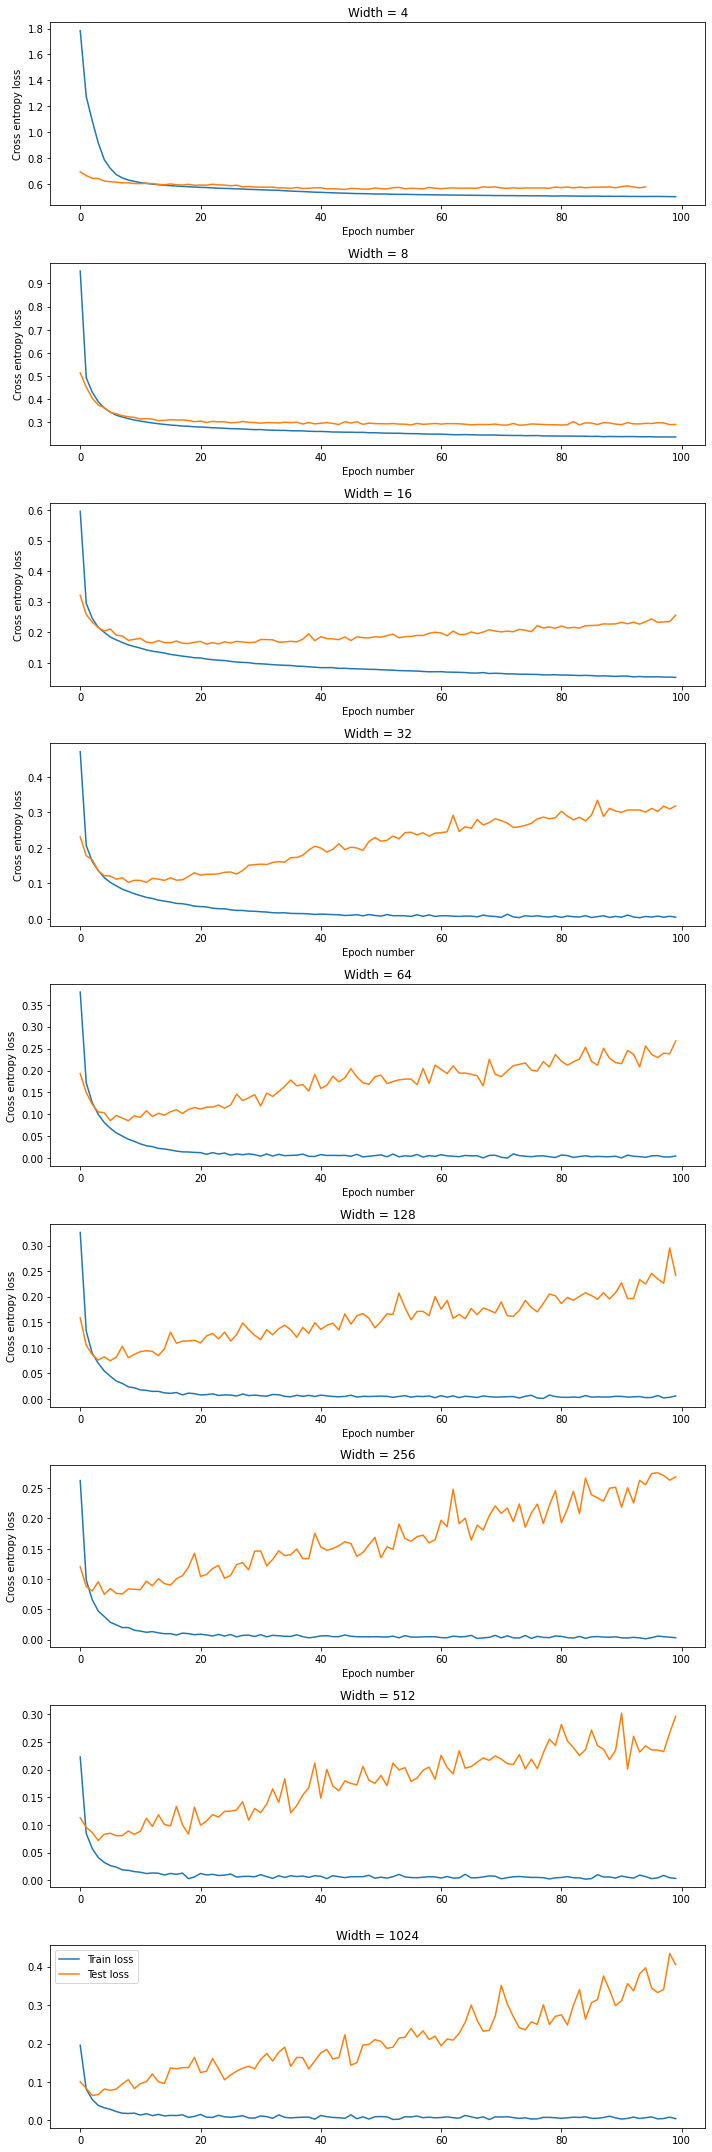

In [ ]:
figure, axis = plt.subplots(9, 1)
figure.set_size_inches(10, 30)

axis[0].plot(train_loss_width_4, label = 'Train loss')
axis[0].plot(test_loss_width_4[5:], label = 'Test loss')
axis[0].set_title('Width = 4')

axis[1].plot(train_loss_width_8, label = 'Train loss')
axis[1].plot(test_loss_width_8, label = 'Test loss')
axis[1].set_title('Width = 8')

axis[2].plot(train_loss_width_16, label = 'Train loss')
axis[2].plot(test_loss_width_16, label = 'Test loss')
axis[2].set_title('Width = 16')

axis[3].plot(train_loss_width_32, label = 'Train loss')
axis[3].plot(test_loss_width_32, label = 'Test loss')
axis[3].set_title('Width = 32')

axis[4].plot(train_loss_width_64, label = 'Train loss')
axis[4].plot(test_loss_width_64, label = 'Test loss')
axis[4].set_title('Width = 64')

axis[5].plot(train_loss_width_128, label = 'Train loss')
axis[5].plot(test_loss_width_128, label = 'Test loss')
axis[5].set_title('Width = 128')

axis[6].plot(train_loss_width_256, label = 'Train loss')
axis[6].plot(test_loss_width_256, label = 'Test loss')
axis[6].set_title('Width = 256')

axis[7].plot(train_loss_width_512, label = 'Train loss')
axis[7].plot(test_loss_width_512, label = 'Test loss')
axis[7].set_title('Width = 512')

axis[8].plot(train_loss_width_1024, label = 'Train loss')
axis[8].plot(test_loss_width_1024, label = 'Test loss')
axis[8].set_title('Width = 1024')

for i in range(7):
  axis[i].set_ylabel('Cross entropy loss')
  axis[i].set_xlabel('Epoch number')

plt.tight_layout()

plt.legend()
plt.show()

| Width | Train loss | Test loss |
| --- | --- | --- | 
| 4 |0.5019409208218935 | 0.5766995940238807 | Done
| 8 | 0.23676465355606477 | 0.29092947467212465 | Done
| 16 | 0.05203916475254752 | 0.2553982191962326 | Done
| 32 | 0.0046600624664849795 | 0.31790426523434834 | Done
| 64 | 0.005155906833498998 | 0.2672180018428562 | Done
| 128 | 0.005630129415023815 | 0.24213658236398028 | Done
| 256 | 0.0032022252854672097 | 0.26853884987011123 | Done
| 512 | 0.0031324055021200664 | 0.29676036959314045 | Done
| 1024 | 0.004180758357503216 | 0.40538278790717863 | Done

We found through our experiment that width 4 didn't converge in a 100 epochs. This could be because with really small widths, the neural network doesnt have enough capacity to represent the underlying pattern in the data. The model may not have enough parameters to learn meaningful features, resulting in a poor representation of the data and difficulty in fitting the data. This results in a high train loss. 

We would expect the train loss of a neural network to decrease as the width of the network increases, this is because with a large width, the neural network can capture more complex patterns in the data, resulting in a better fit to the training data. Overall this this is the pattern we observe with some anomalies such as at width 1024 (where the train loss increases). The anomalies could be due to the decrease in stability of the optimization algorithm as wider networks are more likely to have correlated weights, leading to oscillations and instability during training.

I find that the test loss generally increases from width 128 to width 1024, I think this is because a more complex model can fit the training data more closely and hence also capture noise and spurious patterns in the training data, leading to reduced generalisation performance on unseen data.



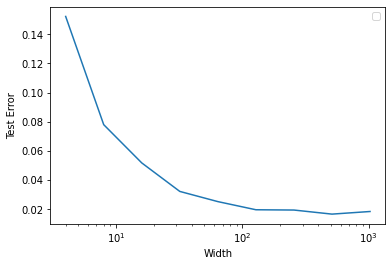

In [ ]:
y_axis = [test_error_width_4[-1],test_error_width_8[-1],test_error_width_16[-1],test_error_width_32[-1],
          test_error_width_64[-1],test_error_width_128[-1],test_error_width_256[-1], test_error_width_512[-1], test_error_width_1024[-1]]

plt.plot([4, 8, 16, 32, 64, 128, 256, 512, 1024], y_axis)
plt.xlabel('Width')
plt.ylabel('Test Error')
plt.xscale('log')

plt.legend()
plt.show();

The test error plot paints a clearer image. We can see for very small widths such as 4 and 8, the test error is very large as the model is underfitting the training data and has a large bias leading to a high test error. As the width increases, the model's capacity to fit the training data increases, and the bias decreases, resulting in a decrease in the test error. 

We also find that increasing the width past 256 doesn't significantly affect the test error. This is supported by [Neyshabur et al., 2018], which shows that the test error can continue to decrease, or at least not increase, even as the number of parameters becomes very large.

Overall, the paper by Neyshabur et al. (2018) challenged the conventional wisdom that over-parametrization is always harmful to the generalisation performance of neural networks. Our result supports this as a width of 1024 is quite over parametrized but it doesn't lead to an increase in test error.


#Part III: Extension to CIFAR10

### Task 10: Test the performance on CIFAR10

In [ ]:
class Net(nn.Module):
  def __init__(self, dim, nclass, width_list):
      """
      Initializes a fully connected neural network with the specified dimensions.

      Inputs:
      - dim : the dimension of the input.
      - nclass : the number of output classes for the prediction problem.
      - width_list : a list of width for each layer. The length of this list is the depth of the neural network.
      """
      super().__init__()
      self.flatten = nn.Flatten() # Define the flatten layer
      self.fc_layers = nn.ModuleList()
      prev_width = dim
      for width in width_list:
          self.fc_layers.append(nn.Linear(prev_width, width)) # Define the fully connected layer
          prev_width = width
      self.fc_out = nn.Linear(prev_width, nclass) # Define the output layer
      self.relu = nn.ReLU() # Define the ReLU activation layer

  def forward(self, input):
      """Passes the input through the layers of the network and returns the output."""
      input = self.flatten(input)
      for fc in self.fc_layers:
          input = fc(input)
          input = self.relu(input)
      output = self.fc_out(input)
      return output

In [ ]:
# Define the hyperparameters
batch_size = 128
dim_cifar = 3072
dim_mnist = 28 * 28
nclass = 10
width = [2048, 1024, 512, 256, 128, 64]
learning_rate = 0.001
epoch_limit = 50

# Load the CIFAR 10 dataset
train_set_cifar, test_set_cifar = loading_data(batch_size, cifar_train, cifar_test)

In [ ]:
net_cifar = Net(dim_cifar, nclass, width)

# Define the adam optimizer
optimizer_cifar = torch.optim.Adam(net_cifar.parameters(), lr=learning_rate)

train_loss_cifar, test_loss_cifar, test_error_cifar = run_epochs(epoch_limit, train_set_cifar, test_set_cifar, net_cifar, optimizer_cifar, criterion)

Epoch: 0 | Train Loss: 1.9883776211067843 | Test Loss: 1.875868957253951 | Test Error: 0.7028
Epoch: 1 | Train Loss: 1.8169471979751002 | Test Loss: 1.769145615493195 | Test Error: 0.6503
Epoch: 2 | Train Loss: 1.715180072942963 | Test Loss: 1.6811620826962628 | Test Error: 0.6083
Epoch: 3 | Train Loss: 1.6283190722965524 | Test Loss: 1.6323186581647848 | Test Error: 0.5891
Epoch: 4 | Train Loss: 1.566528173358849 | Test Loss: 1.551814464074147 | Test Error: 0.5574
Epoch: 5 | Train Loss: 1.5148004281246448 | Test Loss: 1.5528743146341057 | Test Error: 0.5611
Epoch: 6 | Train Loss: 1.4723214450699593 | Test Loss: 1.5029729514182368 | Test Error: 0.5347
Epoch: 7 | Train Loss: 1.4393117068063876 | Test Loss: 1.4588128433951848 | Test Error: 0.5165
Epoch: 8 | Train Loss: 1.401286743181136 | Test Loss: 1.4480283124537408 | Test Error: 0.5181
Epoch: 9 | Train Loss: 1.3768781219297053 | Test Loss: 1.4083327341683303 | Test Error: 0.5028
Epoch: 10 | Train Loss: 1.335023423594892 | Test Loss: 1

In [ ]:
print(train_loss_cifar)
print(test_loss_cifar)
print(test_error_cifar)

[1.9883776211067843, 1.8169471979751002, 1.715180072942963, 1.6283190722965524, 1.566528173358849, 1.5148004281246448, 1.4723214450699593, 1.4393117068063876, 1.401286743181136, 1.3768781219297053, 1.335023423594892, 1.311582933301511, 1.2827943670170388, 1.248557846259583, 1.2161791958772312, 1.1946096342542898, 1.1556887870554424, 1.1265731754205417, 1.0968202887593632, 1.0609382947387598, 1.0317584639010222, 1.0058692974202774, 0.9631757522787889, 0.9354378134393326, 0.9028280587757335, 0.877241298670659, 0.8413683000732871, 0.8068268963747927, 0.775437590411252, 0.7456306120013947, 0.7191634106514094, 0.6876465614189577, 0.665681346221958, 0.6433443360011596, 0.6108762637123732, 0.5879200677127789, 0.556614041404651, 0.5458520830744673, 0.529322759727078, 0.5001834865726168, 0.473207618650573, 0.4657591968546133, 0.43999664493076635, 0.4280147616515684, 0.43644713574205823, 0.41238698744408003, 0.3854408408217418, 0.3848277055241568, 0.361344692080527, 0.36479064353439206]
[1.87586

I show that my new model is working. The key difference here is that the width of each layers is different (half of the one before). This is good to use because it makes the neural network more efficient by reducing the number of parameters. Also deeper neural networks are more prone to overfitting where they memorise the tarining data instead of learn generalisable patterns and reducing the width as the layers go on helps prevent this.

This model although worked only achieves a test accuracy of 50.83% (100*(1-0.4917)). Next I will be aiming to achieve a test accuracy higher than 55%

The question also about whether its easier to train on the CIFAR 10 dataset or MNIST dataset. Its easier to train a neural network on a MNIST dataset because of a few reasons:

-Complexity: MNIST is a greyscale dataset and have a 28by 28 resolution. CIFAR-10 has colour images and has a resolution of 32 by 32. Thus it is harder to train a neural network on CIFAR 10 dataset as it has to learn more complex patterns. 

-Size: The CIFAR-10 dataset is smaller in terms of the number of images, with 50,000 training images and 10,000 test images, compared to the MNIST dataset, which has 60,000 training images and 10,000 test images.

Due to the simplicity of the MNIST dataset over the CIFAR 10 dataset, it is easier to achieve higher accuracy. 

###Bonus task

Lets now try a new neural network architecture.

I have now added a dropout layer (probability based), changed ReLU to Leaky ReLU activation and chnaged optimizer to Adam W.

Dropout layer helps to prevent the neurons from co-adapting and overfitting to the training data. Hence can increase accuracy on unseen data. I did confirm online that having a dropout layer still makes the model classified as having fully connected layers.


The main difference between the two is that Leaky ReLU allows for a small, non-zero gradient when the input is negative, whereas ReLU has a gradient of zero for negative inputs. Thus Leaky ReLU can help to prevent neurons from dying and improve the overall performance of the network.


Adam W optimizer is an extension of Adam optimizer. Adam W includes weight decay preventing weight values from growing too fast. This helps the generalisation performance of the model



In [ ]:
class Net(nn.Module):
    def __init__(self, dim, nclass, width_list, dropout_prob):
        """
        Initializes a fully connected neural network with the specified dimensions.

        Inputs:
        - dim : the dimension of the input.
        - nclass : the number of output classes for the prediction problem.
        - width_list : a list of width for each layer. The length of this list is the depth of the neural network.
        - dropout_prob: dropout probability
        """
        super().__init__()
        self.flatten = nn.Flatten() # Define the flatten layer
        self.fc_layers = nn.ModuleList()
        prev_width = dim
        for width in width_list:
            self.fc_layers.append(nn.Linear(prev_width, width)) # Define the fully connected layer
            self.fc_layers.append(nn.Dropout(p=dropout_prob)) # Add dropout layer
            self.fc_layers.append(nn.LeakyReLU()) # Use leaky ReLU activation
            prev_width = width
        self.fc_out = nn.Linear(prev_width, nclass) # Define the output layer

    def forward(self, input):
        """Passes the input through the layers of the network and returns the output."""
        input = self.flatten(input)
        for layer in self.fc_layers:
            input = layer(input)
        output = self.fc_out(input)
        return output

I first tried varying the learning rate from 0.1 to 0.0001 as the model train for more epochs. However even with this the model wasn't able to get the accuracy higher than 55%. 

A high learning rate can cause the model to overshoot the minimum, while a low learning rate can cause the model to get stuck in a suboptimal region. By using a varying learning rate, the model can start with a high learning rate to make larger updates to the parameters and quickly converge to a minimum, then decrease the learning rate to make smaller updates as it gets closer to the minimum, which can help to fine-tune the parameters and improve accuracy. 

Then I proceeded with the following solution where lowered the learning rate to 0.0001 and ran the model for more epochs than before.

In [ ]:
# Define the hyperparameters
batch_size = 128
dim_cifar = 3072
dim_mnist = 28 * 28
nclass = 10
width = [1500, 700, 300, 150]
learning_rate = 0.0001
epoch_limit = 100
dropout_prob=0.33

In [ ]:
net_cifar = Net(dim_cifar, nclass, width, dropout_prob)

# Define the adam optimizer
optimizer_cifar = torch.optim.AdamW(net_cifar.parameters(), lr=learning_rate)

train_loss_cifar, test_loss_cifar, test_error_cifar = run_epochs(epoch_limit, train_set_cifar, test_set_cifar, net_cifar, optimizer_cifar, criterion)

Epoch: 0 | Train Loss: 2.073987193424683 | Test Loss: 1.8856472274925136 | Test Error: 0.6845
Epoch: 1 | Train Loss: 1.8869562920402079 | Test Loss: 1.7889407058305378 | Test Error: 0.6512
Epoch: 2 | Train Loss: 1.8009583620768983 | Test Loss: 1.720232916783683 | Test Error: 0.6213
Epoch: 3 | Train Loss: 1.7410738074870975 | Test Loss: 1.6443711881396137 | Test Error: 0.5906
Epoch: 4 | Train Loss: 1.695886362848989 | Test Loss: 1.6328143877319143 | Test Error: 0.5777
Epoch: 5 | Train Loss: 1.6552180435956287 | Test Loss: 1.5620947336848778 | Test Error: 0.552
Epoch: 6 | Train Loss: 1.6196976320822831 | Test Loss: 1.537769746176804 | Test Error: 0.547
Epoch: 7 | Train Loss: 1.594366982160017 | Test Loss: 1.5192348911792417 | Test Error: 0.5472
Epoch: 8 | Train Loss: 1.5657706812519552 | Test Loss: 1.4870687104478668 | Test Error: 0.5281
Epoch: 9 | Train Loss: 1.546178173226164 | Test Loss: 1.4905623529530778 | Test Error: 0.5325
Epoch: 10 | Train Loss: 1.5229551209818066 | Test Loss: 1.

In [ ]:
print(train_loss_cifar)
print(test_loss_cifar)
print(test_error_cifar)

[2.073987193424683, 1.8869562920402079, 1.8009583620768983, 1.7410738074870975, 1.695886362848989, 1.6552180435956287, 1.6196976320822831, 1.594366982160017, 1.5657706812519552, 1.546178173226164, 1.5229551209818066, 1.5055282902534661, 1.4855965372851438, 1.4730573465757053, 1.4497160381063476, 1.4370006804576005, 1.4251348240601132, 1.403826159894314, 1.393292445660857, 1.3781965074636746, 1.3653481781025372, 1.3556828151273606, 1.3395860368943275, 1.32474235591986, 1.315196306809135, 1.3046089866582085, 1.2920185403750681, 1.2778869643235755, 1.27164250718968, 1.2623794650482705, 1.2474313812792455, 1.2409210031294762, 1.2269757153737881, 1.2249057795995337, 1.2023996508030026, 1.1948744031169531, 1.193131267872003, 1.1777323751193483, 1.1666722169617558, 1.159665338371111, 1.1470857546152666, 1.1424382937228894, 1.1314105740593523, 1.125533457454818, 1.112113968033315, 1.0993567653324292, 1.0975518755595703, 1.076329150163304, 1.0757537386606417, 1.069695888730266, 1.05506556402996

Task accomplised as I achieved a test accuracy of 57.63% (100*(1-0.4237)).